# TSA(TimeSeries Analysis) for PHM Motor

## 1. Data Review

In [385]:
import numpy as np
import pandas as pd
import datetime

import seaborn as sns
import matplotlib.pyplot as plt
from colorama import Fore
from datetime import datetime, date 
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU
from fbprophet import Prophet
from statsmodels.tsa.stattools import adfuller
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
import pmdarima as pm

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from fbprophet import Prophet
import math

import warnings
warnings.filterwarnings('ignore')

np.random.seed(7)

%matplotlib inline

In [294]:
df = pd.read_csv('./PHM_motor_data/train_1st_Normal.csv')
df.head()

Unnamed: 0  1st_Normal_c1  1st_Normal_c2
0           0      -0.051653      -4.660513
1           1      -0.052279       5.688017
2           2      -0.516792      -3.836329
3           3       0.343794       4.335185
4           4      -0.052666      -0.429551

In [295]:
df.columns

Index(['Unnamed: 0', '1st_Normal_c1', '1st_Normal_c2'], dtype='object')

In [296]:
df.rename(columns={'Unnamed: 0':'ds'}, inplace=True)

In [297]:
df.columns

Index(['ds', '1st_Normal_c1', '1st_Normal_c2'], dtype='object')

In [298]:
df.shape

(15657840, 3)

In [299]:
df['ds'] = df['ds'] * 0.1
df['ds']

0                 0.0
1                 0.1
2                 0.2
3                 0.3
4                 0.4
              ...    
15657835    1565783.5
15657836    1565783.6
15657837    1565783.7
15657838    1565783.8
15657839    1565783.9
Name: ds, Length: 15657840, dtype: float64

In [300]:
#df['ds'] = pd.to_datetime(df['ds'], unit='ms')
#df.head().style.set_properties(subset=['ds'], **{'background-color': 'dodgerblue'})

In [301]:
df['ds'] = pd.date_range('16/11/2020', periods=15657840, freq='95U')
df.head().style.set_properties(subset=['ds'], **{'background-color': 'dodgerblue'})

In [302]:
# 0.4s
#sample_size = int(0.00028 * len(df))

# 4s
sample_size = int(0.0028 * len(df))

df = df.iloc[:sample_size, :]

In [303]:
df

ds  1st_Normal_c1  1st_Normal_c2
0     2020-11-16 00:00:00.000000      -0.051653      -4.660513
1     2020-11-16 00:00:00.000095      -0.052279       5.688017
2     2020-11-16 00:00:00.000190      -0.516792      -3.836329
3     2020-11-16 00:00:00.000285       0.343794       4.335185
4     2020-11-16 00:00:00.000380      -0.052666      -0.429551
...                          ...            ...            ...
43836 2020-11-16 00:00:04.164420       0.161330       2.048766
43837 2020-11-16 00:00:04.164515       0.123928       1.833891
43838 2020-11-16 00:00:04.164610       0.146786      -0.224690
43839 2020-11-16 00:00:04.164705       0.312055      -3.376792
43840 2020-11-16 00:00:04.164800       0.272045      -2.998690

[43841 rows x 3 columns]

In [304]:
df.shape

(43841, 3)

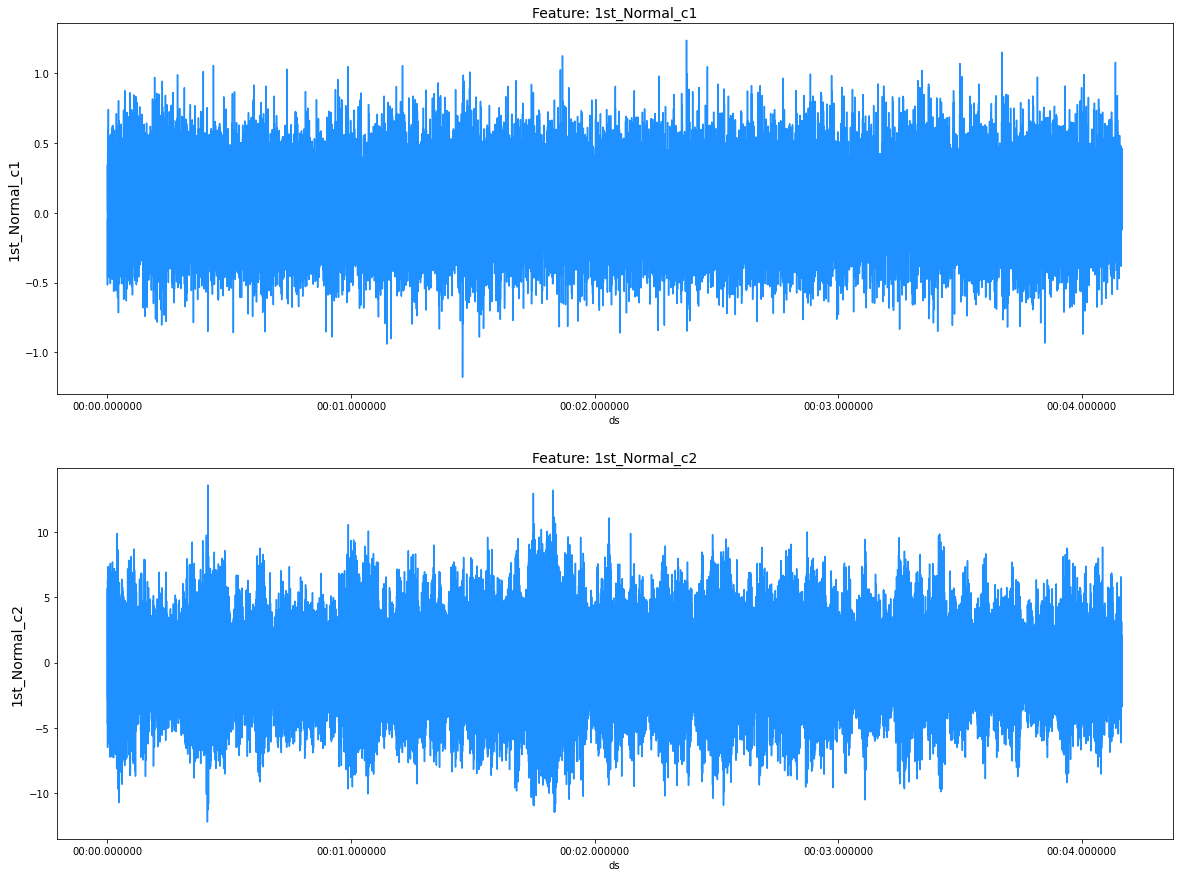

In [305]:
f, ax = plt.subplots(nrows=2, ncols=1, figsize=(20, 15))

for i, column in enumerate(df.drop('ds', axis=1).columns):
    sns.lineplot(x=df['ds'], y=df[column].fillna(method='ffill'), ax=ax[i], color='dodgerblue')
    ax[i].set_title('Feature: {}'.format(column), fontsize=14)
    ax[i].set_ylabel(ylabel=column, fontsize=14)
    ax[i].set_xlim()          # date range

# 2. Data Processing

### Chronological Order and Equidistant Timestamps

In [306]:
df =df.sort_values(by='ds')

# Check the intervals
df['ds_delta'] = df['ds'] - df['ds'].shift(1)
df[['ds', 'ds_delta']].head()

ds               ds_delta
0 2020-11-16 00:00:00.000000                    NaT
1 2020-11-16 00:00:00.000095 0 days 00:00:00.000095
2 2020-11-16 00:00:00.000190 0 days 00:00:00.000095
3 2020-11-16 00:00:00.000285 0 days 00:00:00.000095
4 2020-11-16 00:00:00.000380 0 days 00:00:00.000095

In [307]:
df.shape

(43841, 4)

In [308]:
df['ds_delta'].sum(), df['ds_delta'].count()

(Timedelta('0 days 00:00:04.164800'), 43840)

## 2.1 Handle Missing

As we can see, the dataset has some null values.

In [309]:
df = df.drop('ds_delta', axis=1)
df.isna().sum()

ds               0
1st_Normal_c1    0
1st_Normal_c2    0
dtype: int64

Text(0, 0.5, '1st_Normal_c2')

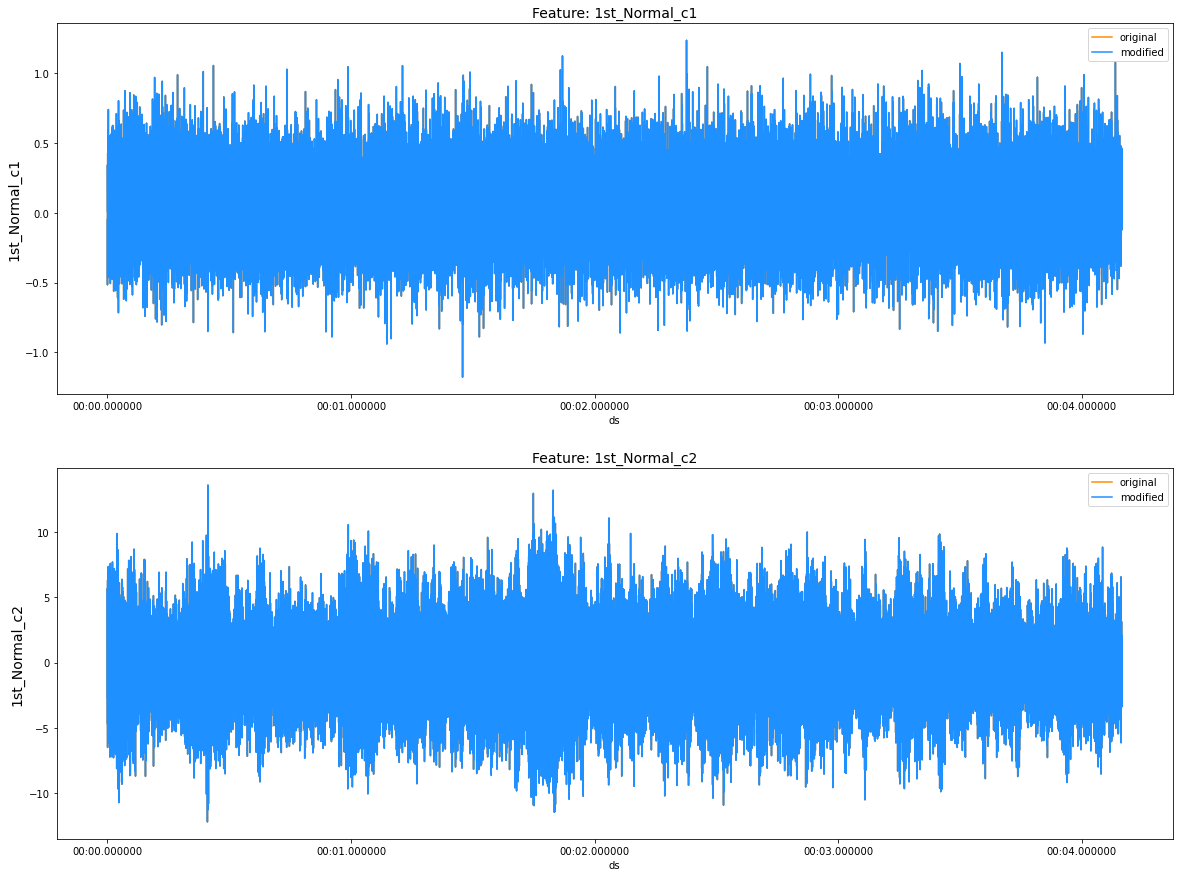

In [310]:
# 0으로 기록된 데이터 처리
f, ax = plt.subplots(nrows=2, ncols=1, figsize=(20, 15))

old_1st_Normal_c1 = df['1st_Normal_c1'].copy()
df['1st_Normal_c1'] = df['1st_Normal_c1'].replace(0, np.nan)

sns.lineplot(x=df['ds'], y=old_1st_Normal_c1, ax=ax[0], color='darkorange', label='original')
sns.lineplot(x=df['ds'], y=df['1st_Normal_c1'].fillna(np.inf), ax=ax[0], color='dodgerblue', label='modified')

ax[0].set_title('Feature: 1st_Normal_c1', fontsize=14)
ax[0].set_ylabel(ylabel='1st_Normal_c1', fontsize=14)
#ax[0].set_xlim([1, 10000])

old_1st_Normal_c2 = df['1st_Normal_c2'].copy()
df['1st_Normal_c2'] = df['1st_Normal_c2'].replace(0, np.nan)

sns.lineplot(x=df['ds'], y=old_1st_Normal_c2, ax=ax[1], color='darkorange', label='original')
sns.lineplot(x=df['ds'], y=df['1st_Normal_c2'].fillna(np.inf), ax=ax[1], color='dodgerblue', label='modified')

ax[1].set_title('Feature: 1st_Normal_c2', fontsize=14)
ax[1].set_ylabel(ylabel='1st_Normal_c2', fontsize=14)
#ax[1].set_xlim([1, 10000])


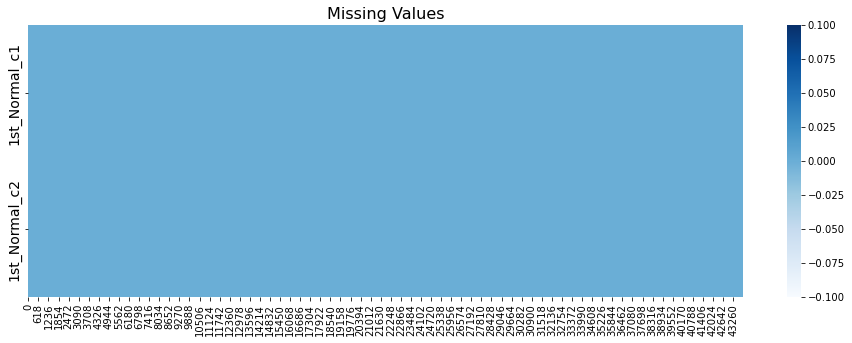

In [311]:
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(16,5))

sns.heatmap(df.drop('ds', axis=1).T.isna(), cmap='Blues')                 # df.T row와 columns 바꾸기
ax.set_title('Missing Values', fontsize=16)

for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(14)
plt.show()

## 2.2 Smoothing data / Resampling

Resampling can provide additional information on the data. There are two types of resampling:

- Upsampling is when the frequence of samples is increased (e.q. days to hours)
- Downsampling is when the frequence of samples is decreased (e.q. days to weeks)

In [312]:
df['ds']

0       2020-11-16 00:00:00.000000
1       2020-11-16 00:00:00.000095
2       2020-11-16 00:00:00.000190
3       2020-11-16 00:00:00.000285
4       2020-11-16 00:00:00.000380
                   ...            
43836   2020-11-16 00:00:04.164420
43837   2020-11-16 00:00:04.164515
43838   2020-11-16 00:00:04.164610
43839   2020-11-16 00:00:04.164705
43840   2020-11-16 00:00:04.164800
Name: ds, Length: 43841, dtype: datetime64[ns]

In this example. we will do some downsampling with the resample() function (similar to groupby and aggregate as mean).

0       2020-11-16 00:00:00.000000
1       2020-11-16 00:00:00.000095
2       2020-11-16 00:00:00.000190
3       2020-11-16 00:00:00.000285
4       2020-11-16 00:00:00.000380
                   ...            
43836   2020-11-16 00:00:04.164420
43837   2020-11-16 00:00:04.164515
43838   2020-11-16 00:00:04.164610
43839   2020-11-16 00:00:04.164705
43840   2020-11-16 00:00:04.164800
Name: ds, Length: 43841, dtype: datetime64[ns]
0      2020-11-16 00:00:00.000000
1      2020-11-16 00:00:00.000950
2      2020-11-16 00:00:00.001900
3      2020-11-16 00:00:00.002850
4      2020-11-16 00:00:00.003800
                  ...            
4380   2020-11-16 00:00:04.161000
4381   2020-11-16 00:00:04.161950
4382   2020-11-16 00:00:04.162900
4383   2020-11-16 00:00:04.163850
4384   2020-11-16 00:00:04.164800
Name: ds, Length: 4385, dtype: datetime64[ns]
0     2020-11-16 00:00:00.000000
1     2020-11-16 00:00:00.009500
2     2020-11-16 00:00:00.019000
3     2020-11-16 00:00:00.028500
4     2020-11-16

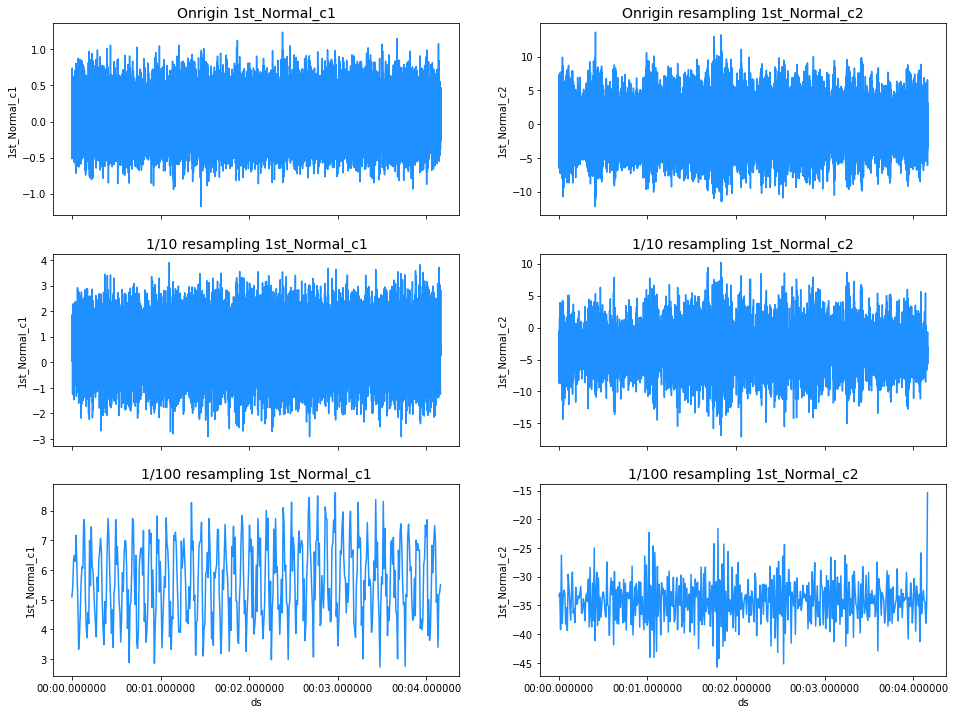

In [313]:
fig, ax = plt.subplots(nrows=3, ncols=2, sharex=True, figsize=(16,12))


sns.lineplot(x=df['ds'], y=df['1st_Normal_c1'], color='dodgerblue', ax=ax[0, 0])
ax[0, 0].set_title('Onrigin 1st_Normal_c1', fontsize=14)
print(df['ds'])

#resampled_df = df[['ds','1st_Normal_c1']]
resampled_df = df.set_index(df['ds']).resample('950U').sum().reset_index(drop=False)
sns.lineplot(x=resampled_df['ds'], y=resampled_df['1st_Normal_c1'], color='dodgerblue', ax=ax[1, 0])
ax[1, 0].set_title('1/10 resampling 1st_Normal_c1', fontsize=14)
print(resampled_df['ds'])

resampled_df = df.set_index(df['ds']).resample('9500U').sum().reset_index(drop=False)
sns.lineplot(x=resampled_df['ds'], y=resampled_df['1st_Normal_c1'], color='dodgerblue', ax=ax[2, 0])
ax[2, 0].set_title('1/100 resampling 1st_Normal_c1', fontsize=14)
print(resampled_df['ds'])

for i in range(3):
    ax[i, 1].set_xlim()

sns.lineplot(df['ds'], df['1st_Normal_c2'], color='dodgerblue', ax=ax[0, 1])
ax[0, 1].set_title('Onrigin resampling 1st_Normal_c2', fontsize=14)

#resampled_df = df[['ds','1st_Normal_c2']]
resampled_df = df.set_index(df['ds']).resample('950U').sum().reset_index(drop=False)
sns.lineplot(resampled_df['ds'], resampled_df['1st_Normal_c2'], color='dodgerblue', ax=ax[1, 1])
ax[1, 1].set_title('1/10 resampling 1st_Normal_c2', fontsize=14)

resampled_df = df.set_index(df['ds']).resample('9500U').sum().reset_index(drop=False)
sns.lineplot(x=resampled_df['ds'], y=resampled_df['1st_Normal_c2'], color='dodgerblue', ax=ax[2, 1])
ax[2, 1].set_title('1/100 resampling 1st_Normal_c2', fontsize=14)

for i in range(3):
    ax[i, 1].set_xlim()
plt.show()

In [314]:
downsample = df[['ds', '1st_Normal_c1', '1st_Normal_c2']].set_index(df['ds']).resample('950U').mean().reset_index(drop=False)
df = downsample.copy()

In [315]:
df

ds  1st_Normal_c1  1st_Normal_c2
0    2020-11-16 00:00:00.000000       0.005162      -0.243085
1    2020-11-16 00:00:00.000950       0.120709      -0.867241
2    2020-11-16 00:00:00.001900       0.162908      -0.127798
3    2020-11-16 00:00:00.002850       0.138114      -0.109674
4    2020-11-16 00:00:00.003800       0.186586      -0.079596
...                         ...            ...            ...
4380 2020-11-16 00:00:04.161000       0.028045      -0.222593
4381 2020-11-16 00:00:04.161950       0.132557      -0.068970
4382 2020-11-16 00:00:04.162900       0.281974      -0.573680
4383 2020-11-16 00:00:04.163850       0.080598      -0.370274
4384 2020-11-16 00:00:04.164800       0.272045      -2.998690

[4385 rows x 3 columns]

## 2.3 Stationarity

Some time-series models, such as such as ARIMA, assume that the underlying data is stationary. Stationarity describes that the time-series has
>
- constant mean and mean is not time-dependent
- constant variance and variance is not time-dependent
- constant covariance and convariance is not time-dependent

The check for stationarity can be done via three diffenent approaches:
>
1. visually: plot time series and check for trends or seasonality
3. basic statictics: split time series and compare the mean and variance of each partition
3. statiscal test: Augmented Dickey Fuller test

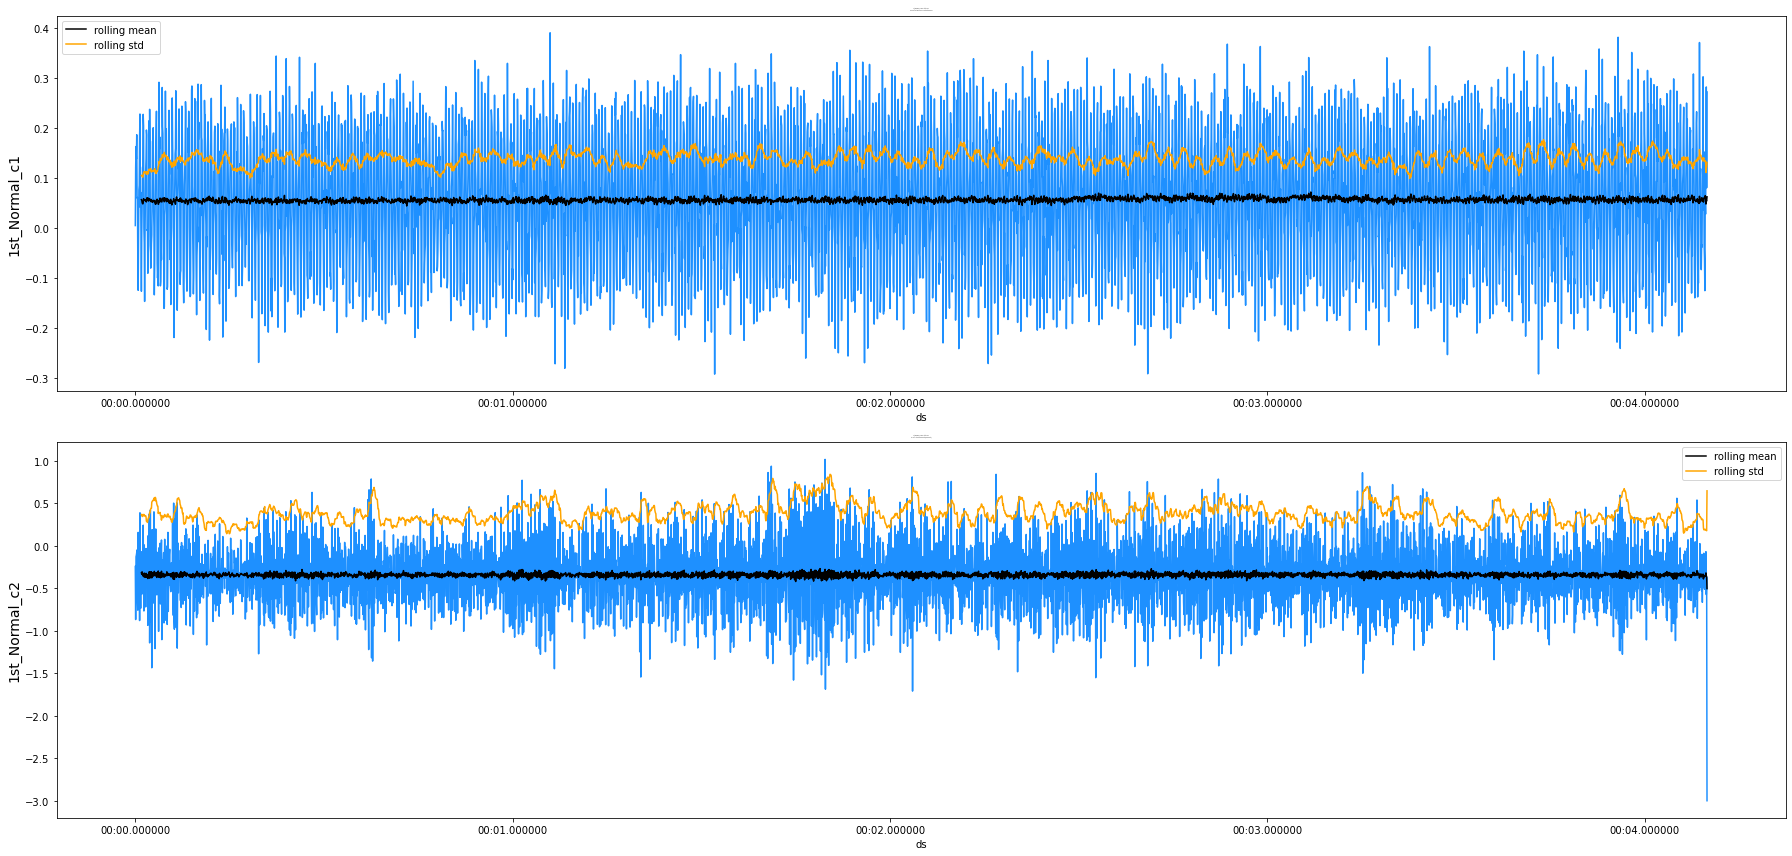

In [317]:
rolling_window = 18

f, ax = plt.subplots(nrows=2, ncols=1, figsize=(25,12))

sns.lineplot(x=df['ds'], y=df['1st_Normal_c1'], ax=ax[0], color='dodgerblue')
sns.lineplot(x=df['ds'], y=df['1st_Normal_c1'].rolling(rolling_window).mean(), ax=ax[0], color='black', label='rolling mean')
sns.lineplot(x=df['ds'], y=df['1st_Normal_c1'].rolling(rolling_window).std(), ax=ax[0], color='orange', label='rolling std')
ax[0].set_title('1st_Normal_c1: Non-stationary \nnon-constant mean & non-constant variance', fontsize=1)
ax[0].set_ylabel(ylabel='1st_Normal_c1', fontsize=14)
ax[0].set_xlim()

sns.lineplot(x=df['ds'], y=df['1st_Normal_c2'], ax=ax[1], color='dodgerblue')
sns.lineplot(x=df['ds'], y=df['1st_Normal_c2'].rolling(rolling_window).mean(), ax=ax[1], color='black', label='rolling mean')
sns.lineplot(x=df['ds'], y=df['1st_Normal_c2'].rolling(rolling_window).std(), ax=ax[1], color='orange', label='rolling std')
ax[1].set_title('1st_Normal_c2: Non-stationary \nvariance is time-dependent (seasonality)', fontsize=1)
ax[1].set_ylabel(ylabel='1st_Normal_c2', fontsize=14)
ax[1].set_xlim()

plt.tight_layout()
plt.show()

### 2.3.1 Augmented Dickey-Fully(ADF)

Augmented Dickey-Fuller (ADF) test is a type of statistical test called a unit root test. Unit roots are a cause for non-stationarity.

- Null Hypothesis (H0): Time series has a unit root. (Time series is not stationary).
- Alternate Hypothesis (H1): Time series has no unit root (Time series is stationary).


If the null hypothesis can be rejected, we can conclude that the time series is stationary.

There are two ways to rejects the null hypothesis:

On the one hand, the null hypothesis can be rejected if the p-value is below a set significance level. The defaults significance level is 5%
>
- p-value > significance level (default: 0.05): Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.
- p-value <= significance level (default: 0.05): Reject the null hypothesis (H0), the data does not have a unit root and is stationary. On the other hand, the null hypothesis can be rejects if the test statistic is less than the critical value.

- ADF statistic > critical value: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.

- ADF statistic < critical value: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

In [318]:
c1_result = adfuller(df['1st_Normal_c1'].values)
c1_result

(-13.202391935580184,
 1.0878004986388631e-24,
 29,
 4355,
 {'1%': -3.4318524474416483,
  '5%': -2.862203897664062,
  '10%': -2.5671233972458647},
 -16698.144970489135)

In [319]:
c2_result = adfuller(df['1st_Normal_c2'].values)
c2_result

(-20.11452860351672,
 0.0,
 31,
 4353,
 {'1%': -3.4318531381537225,
  '5%': -2.8622042027970633,
  '10%': -2.5671235596834574},
 -2739.1111019676)

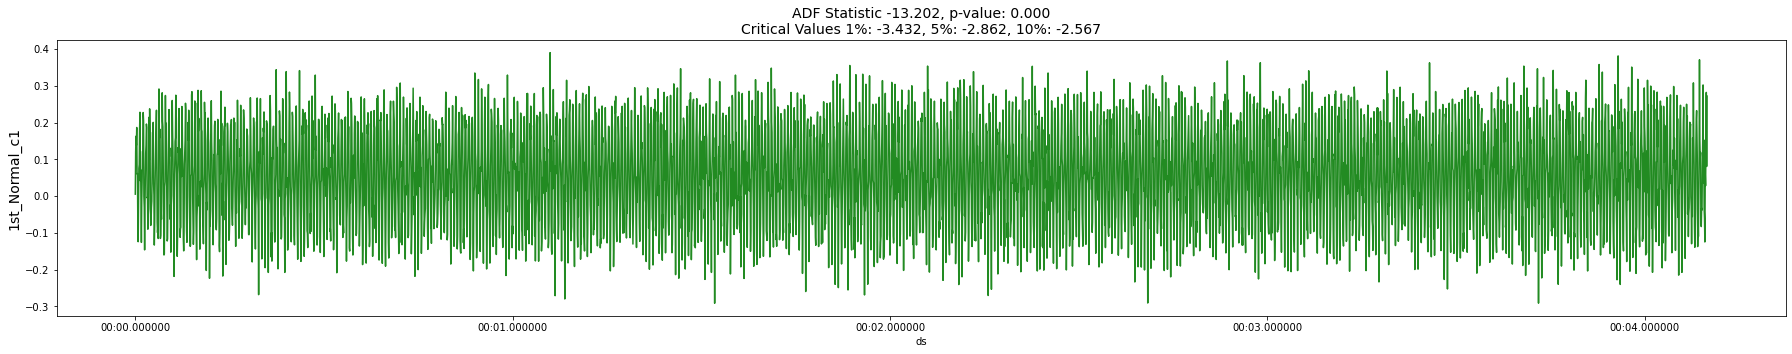

In [320]:
# Thanks to https://www.kaggle.com/iamleonie for this function!
f, ax = plt.subplots(nrows=2, ncols=1, figsize=(25, 9))

def visualize_adfuller_results(series, title, ax):
    result = adfuller(series)
    significance_level = 0.05
    adf_stat = result[0]
    p_val = result[1]
    crit_val_1 = result[4]['1%']
    crit_val_5 = result[4]['5%']
    crit_val_10 = result[4]['10%']

    if (p_val < significance_level) & ((adf_stat < crit_val_1)):
        linecolor = 'forestgreen' 
    elif (p_val < significance_level) & (adf_stat < crit_val_5):
        linecolor = 'orange'
    elif (p_val < significance_level) & (adf_stat < crit_val_10):
        linecolor = 'red'
    else:
        linecolor = 'purple'
    sns.lineplot(x=df['ds'], y=series, ax=ax, color=linecolor)
    ax.set_title(f'ADF Statistic {adf_stat:0.3f}, p-value: {p_val:0.3f}\nCritical Values 1%: {crit_val_1:0.3f}, 5%: {crit_val_5:0.3f}, 10%: {crit_val_10:0.3f}', fontsize=14)
    ax.set_ylabel(ylabel=title, fontsize=14)

visualize_adfuller_results(df['1st_Normal_c1'].values, '1st_Normal_c1', ax[0])
visualize_adfuller_results(df['1st_Normal_c2'].values, '1st_Normal_c2', ax[1])

f.delaxes(ax[1])
plt.tight_layout()
plt.show()

### 2.3.2 Transforming

<AxesSubplot:xlabel='1st_Normal_c1_log', ylabel='Density'>

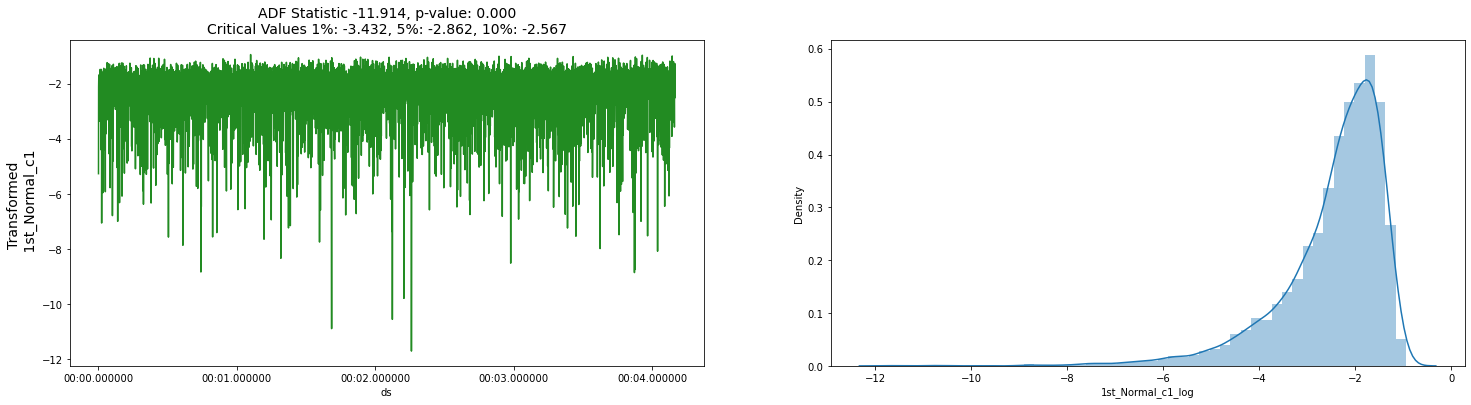

In [321]:
# log Transform of absolute values
#(log transform of negative values will return NaN)

df['1st_Normal_c1_log'] = np.log(abs(df['1st_Normal_c1']))

f, ax = plt.subplots(nrows=1, ncols=2, figsize=(25, 6))
visualize_adfuller_results(df['1st_Normal_c1_log'], 'Transformed \n 1st_Normal_c1', ax[0])

sns.distplot(df['1st_Normal_c1_log'], ax=ax[1])

<AxesSubplot:xlabel='1st_Normal_c2_log', ylabel='Density'>

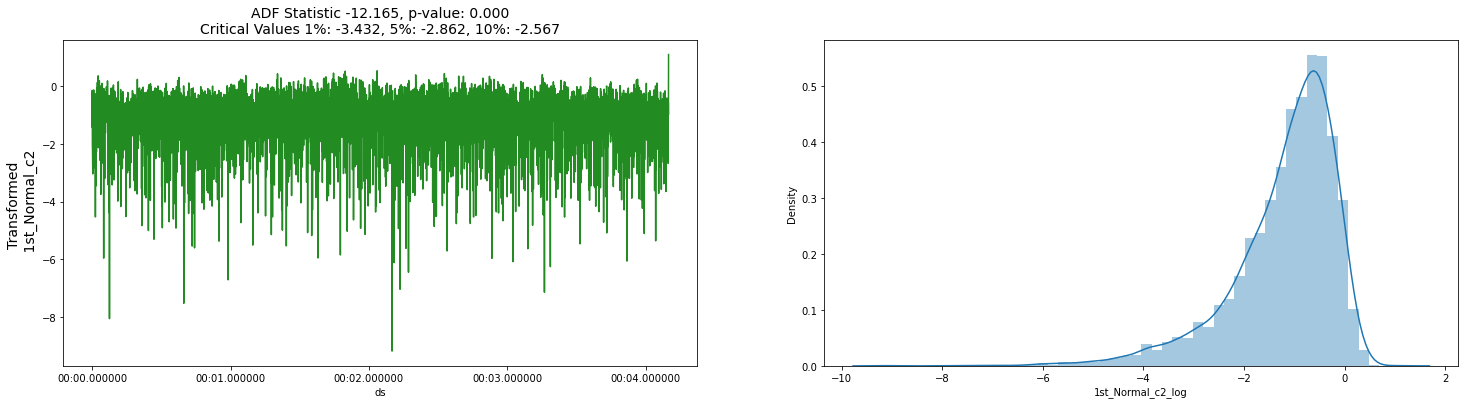

In [322]:
# log Transform of absolute values
#(log transform of negative values will return NaN)

df['1st_Normal_c2_log'] = np.log(abs(df['1st_Normal_c2']))

f, ax = plt.subplots(nrows=1, ncols=2, figsize=(25, 6))
visualize_adfuller_results(df['1st_Normal_c2_log'], 'Transformed \n 1st_Normal_c2', ax[0])

sns.distplot(df['1st_Normal_c2_log'], ax=ax[1])

### 2.3.3 Differencing

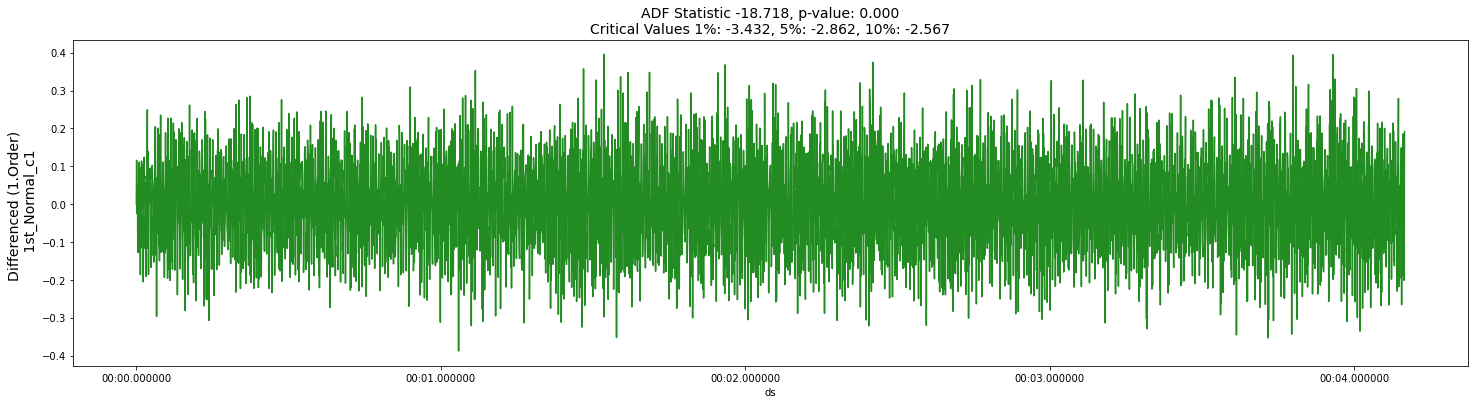

In [323]:
# First Order Diffenencing
ts_diff = np.diff(df['1st_Normal_c1'])
df['1st_Normal_c1_diff_1'] = np.append([0], ts_diff)

f, ax = plt.subplots(nrows=1, ncols=1, figsize=(25, 6))
visualize_adfuller_results(df['1st_Normal_c1_diff_1'], 'Differenced (1.Order) \n 1st_Normal_c1', ax)

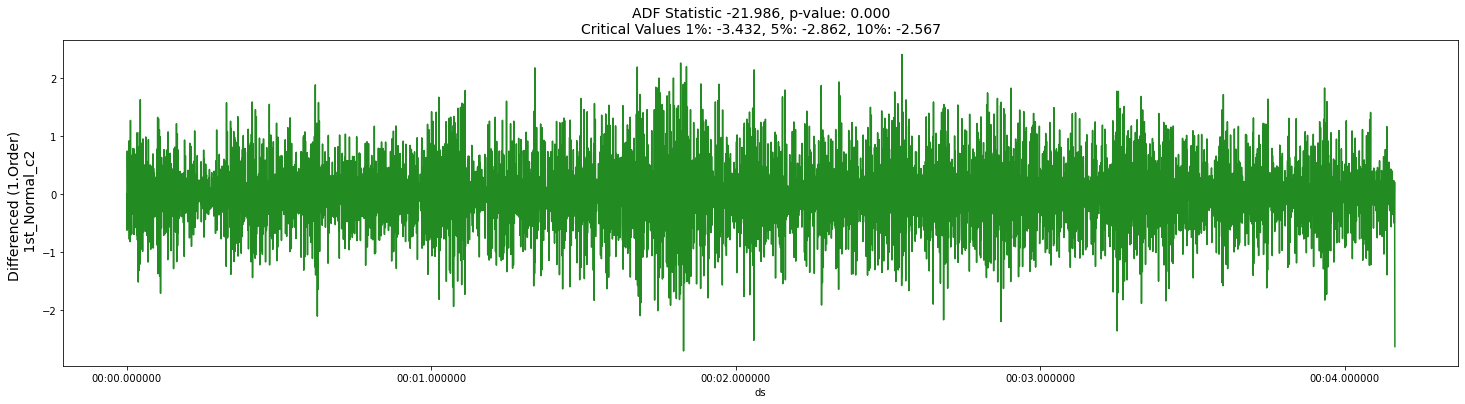

In [324]:
# First Order Diffenencing
ts_diff = np.diff(df['1st_Normal_c2'])
df['1st_Normal_c2_diff_1'] = np.append([0], ts_diff)

f, ax = plt.subplots(nrows=1, ncols=1, figsize=(25, 6))
visualize_adfuller_results(df['1st_Normal_c2_diff_1'], 'Differenced (1.Order) \n 1st_Normal_c2', ax)

# 3. Feature Engineering

In [325]:
df['second'] = pd.DatetimeIndex(df['ds']).second
df['microsecond'] = pd.DatetimeIndex(df['ds']).microsecond

df[['ds','second','microsecond']].head()

ds  second  microsecond
0 2020-11-16 00:00:00.000000       0            0
1 2020-11-16 00:00:00.000950       0          950
2 2020-11-16 00:00:00.001900       0         1900
3 2020-11-16 00:00:00.002850       0         2850
4 2020-11-16 00:00:00.003800       0         3800

In [326]:
df

ds  1st_Normal_c1  1st_Normal_c2  \
0    2020-11-16 00:00:00.000000       0.005162      -0.243085   
1    2020-11-16 00:00:00.000950       0.120709      -0.867241   
2    2020-11-16 00:00:00.001900       0.162908      -0.127798   
3    2020-11-16 00:00:00.002850       0.138114      -0.109674   
4    2020-11-16 00:00:00.003800       0.186586      -0.079596   
...                         ...            ...            ...   
4380 2020-11-16 00:00:04.161000       0.028045      -0.222593   
4381 2020-11-16 00:00:04.161950       0.132557      -0.068970   
4382 2020-11-16 00:00:04.162900       0.281974      -0.573680   
4383 2020-11-16 00:00:04.163850       0.080598      -0.370274   
4384 2020-11-16 00:00:04.164800       0.272045      -2.998690   

      1st_Normal_c1_log  1st_Normal_c2_log  1st_Normal_c1_diff_1  \
0             -5.266340          -1.414343              0.000000   
1             -2.114372          -0.142438              0.115547   
2             -1.814572          -2.057304              0.042199   
3             -1.979679          -2.210245             -0.024794   
4             -1.678865          -2.530794              0.048472   
...                 ...                ...                   ...   
4380          -3.573956          -1.502409             -0.032590   
4381          -2.020743          -2.674087              0.104512   
4382          -1.265941          -0.555684              0.149417   
4383          -2.518280          -0.993511             -0.201376   
4384          -1.301787           1.098176              0.191447   

      1st_Normal_c2_diff_1  second  microsecond  
0                 0.000000       0            0  
1                -0.624156       0          950  
2                 0.739443       0         1900  
3                 0.018124       0         2850  
4                 0.030078       0         3800  
...                    ...     ...          ...  
4380              0.230876       4       161000  
4381              0.153624       4       161950  
4382             -0.504710       4       162900  
4383              0.203405       4       163850  
4384             -2.628416       4       164800  

[4385 rows x 9 columns]

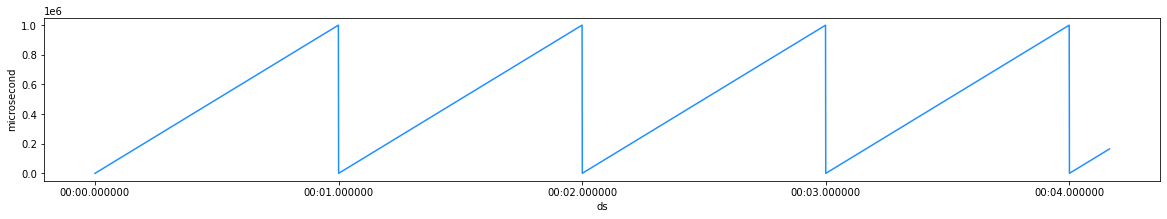

In [327]:
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 3))

sns.lineplot(x=df['ds'], y=df['microsecond'], color='dodgerblue')
ax.set_xlim()
plt.show()

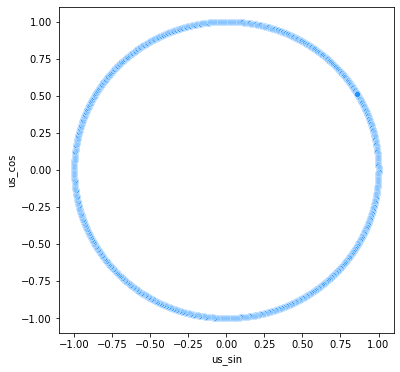

In [328]:
us_in_time = 1000000
df['us_sin'] = np.sin(2*np.pi*df['microsecond']/us_in_time)
df['us_cos'] = np.cos(2*np.pi*df['microsecond']/us_in_time)

f, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))

sns.scatterplot(x=df.us_sin, y=df.us_cos, color='dodgerblue')
plt.show()

## 3.2 TimeSeries Decomposition

Time series decomposition involves thinking of a series as a combination of level, trend, seasonality, and noise components.

These components are defined as follows:
>
- Level: The average value in the series.
- Trend: The increasing or decreasing value in the series.
- Seasonality: The repeating short-term cycle in the series.
- Noise: The random variation in the series.

In [329]:
from statsmodels.tsa.seasonal import seasonal_decompose

core_columns = ['1st_Normal_c1', '1st_Normal_c2']

for column in core_columns:
    decomp = seasonal_decompose(df[column], period=60, model='additive', extrapolate_trend='freq')
    df[f"{column}_trend"] = decomp.trend
    df[f"{column}_seasonal"] = decomp.seasonal

In [330]:
df

ds  1st_Normal_c1  1st_Normal_c2  \
0    2020-11-16 00:00:00.000000       0.005162      -0.243085   
1    2020-11-16 00:00:00.000950       0.120709      -0.867241   
2    2020-11-16 00:00:00.001900       0.162908      -0.127798   
3    2020-11-16 00:00:00.002850       0.138114      -0.109674   
4    2020-11-16 00:00:00.003800       0.186586      -0.079596   
...                         ...            ...            ...   
4380 2020-11-16 00:00:04.161000       0.028045      -0.222593   
4381 2020-11-16 00:00:04.161950       0.132557      -0.068970   
4382 2020-11-16 00:00:04.162900       0.281974      -0.573680   
4383 2020-11-16 00:00:04.163850       0.080598      -0.370274   
4384 2020-11-16 00:00:04.164800       0.272045      -2.998690   

      1st_Normal_c1_log  1st_Normal_c2_log  1st_Normal_c1_diff_1  \
0             -5.266340          -1.414343              0.000000   
1             -2.114372          -0.142438              0.115547   
2             -1.814572          -2.057304              0.042199   
3             -1.979679          -2.210245             -0.024794   
4             -1.678865          -2.530794              0.048472   
...                 ...                ...                   ...   
4380          -3.573956          -1.502409             -0.032590   
4381          -2.020743          -2.674087              0.104512   
4382          -1.265941          -0.555684              0.149417   
4383          -2.518280          -0.993511             -0.201376   
4384          -1.301787           1.098176              0.191447   

      1st_Normal_c2_diff_1  second  microsecond    us_sin    us_cos  \
0                 0.000000       0            0  0.000000  1.000000   
1                -0.624156       0          950  0.005969  0.999982   
2                 0.739443       0         1900  0.011938  0.999929   
3                 0.018124       0         2850  0.017906  0.999840   
4                 0.030078       0         3800  0.023874  0.999715   
...                    ...     ...          ...       ...       ...   
4380              0.230876       4       161000  0.847678  0.530511   
4381              0.153624       4       161950  0.850829  0.525442   
4382             -0.504710       4       162900  0.853951  0.520354   
4383              0.203405       4       163850  0.857041  0.515248   
4384             -2.628416       4       164800  0.860102  0.510123   

      1st_Normal_c1_trend  1st_Normal_c1_seasonal  1st_Normal_c2_trend  \
0                0.055524               -0.006783            -0.340252   
1                0.055514                0.002979            -0.340285   
2                0.055504                0.003637            -0.340317   
3                0.055494                0.009246            -0.340350   
4                0.055484                0.000157            -0.340383   
...                   ...                     ...                  ...   
4380             0.057026               -0.006783            -0.343665   
4381             0.057029                0.002979            -0.343673   
4382             0.057032                0.003637            -0.343681   
4383             0.057035                0.009246            -0.343689   
4384             0.057038                0.000157            -0.343697   

      1st_Normal_c2_seasonal  
0                  -0.032904  
1                   0.022644  
2                   0.000115  
3                  -0.007375  
4                  -0.026703  
...                      ...  
4380               -0.032904  
4381                0.022644  
4382                0.000115  
4383               -0.007375  
4384               -0.026703  

[4385 rows x 15 columns]

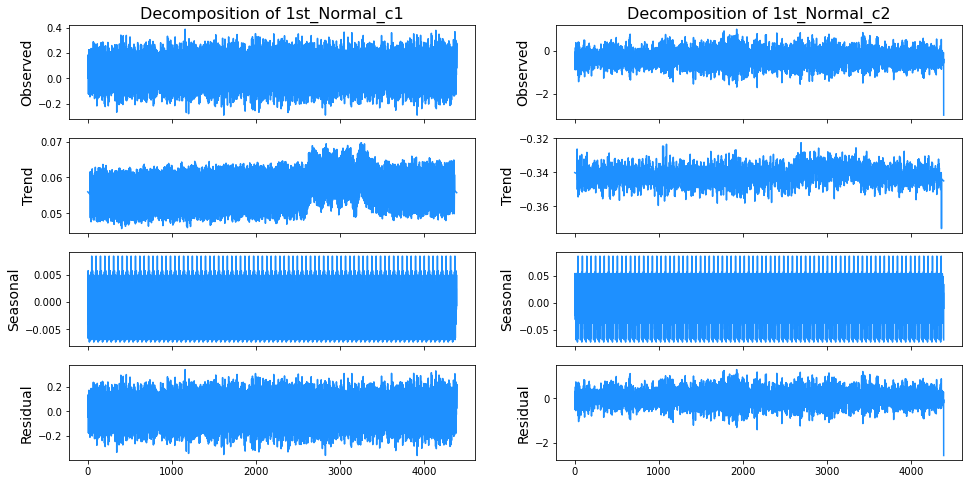

In [331]:
fig, ax = plt.subplots(nrows=4, ncols=2, sharex=True, figsize=(16,8))

for i, column in enumerate(['1st_Normal_c1', '1st_Normal_c2']):
    res = seasonal_decompose(df[column], freq=52, model='additive', extrapolate_trend='freq')
    
    ax[0, i].set_title('Decomposition of {}'.format(column), fontsize=16)
    
    res.observed.plot(ax=ax[0,i], legend=False, color='dodgerblue')
    ax[0, i].set_ylabel('Observed', fontsize=14)
    
    res.trend.plot(ax=ax[1,i], legend=False, color='dodgerblue')
    ax[1, i].set_ylabel('Trend', fontsize=14)
    
    res.seasonal.plot(ax=ax[2,i], legend=False, color='dodgerblue')
    ax[2, i].set_ylabel('Seasonal', fontsize=14)
    
    res.resid.plot(ax=ax[3,i], legend=False, color='dodgerblue')
    ax[3, i].set_ylabel('Residual', fontsize=14)

plt.show()

## 3.3 Lag

We want to calculate each variable with a shift() (lag) to compare the correlationwith the other variables.   

You can see documentation of shift function for more information.

# 4. Explortory Data Analysis

In [332]:
df

ds  1st_Normal_c1  1st_Normal_c2  \
0    2020-11-16 00:00:00.000000       0.005162      -0.243085   
1    2020-11-16 00:00:00.000950       0.120709      -0.867241   
2    2020-11-16 00:00:00.001900       0.162908      -0.127798   
3    2020-11-16 00:00:00.002850       0.138114      -0.109674   
4    2020-11-16 00:00:00.003800       0.186586      -0.079596   
...                         ...            ...            ...   
4380 2020-11-16 00:00:04.161000       0.028045      -0.222593   
4381 2020-11-16 00:00:04.161950       0.132557      -0.068970   
4382 2020-11-16 00:00:04.162900       0.281974      -0.573680   
4383 2020-11-16 00:00:04.163850       0.080598      -0.370274   
4384 2020-11-16 00:00:04.164800       0.272045      -2.998690   

      1st_Normal_c1_log  1st_Normal_c2_log  1st_Normal_c1_diff_1  \
0             -5.266340          -1.414343              0.000000   
1             -2.114372          -0.142438              0.115547   
2             -1.814572          -2.057304              0.042199   
3             -1.979679          -2.210245             -0.024794   
4             -1.678865          -2.530794              0.048472   
...                 ...                ...                   ...   
4380          -3.573956          -1.502409             -0.032590   
4381          -2.020743          -2.674087              0.104512   
4382          -1.265941          -0.555684              0.149417   
4383          -2.518280          -0.993511             -0.201376   
4384          -1.301787           1.098176              0.191447   

      1st_Normal_c2_diff_1  second  microsecond    us_sin    us_cos  \
0                 0.000000       0            0  0.000000  1.000000   
1                -0.624156       0          950  0.005969  0.999982   
2                 0.739443       0         1900  0.011938  0.999929   
3                 0.018124       0         2850  0.017906  0.999840   
4                 0.030078       0         3800  0.023874  0.999715   
...                    ...     ...          ...       ...       ...   
4380              0.230876       4       161000  0.847678  0.530511   
4381              0.153624       4       161950  0.850829  0.525442   
4382             -0.504710       4       162900  0.853951  0.520354   
4383              0.203405       4       163850  0.857041  0.515248   
4384             -2.628416       4       164800  0.860102  0.510123   

      1st_Normal_c1_trend  1st_Normal_c1_seasonal  1st_Normal_c2_trend  \
0                0.055524               -0.006783            -0.340252   
1                0.055514                0.002979            -0.340285   
2                0.055504                0.003637            -0.340317   
3                0.055494                0.009246            -0.340350   
4                0.055484                0.000157            -0.340383   
...                   ...                     ...                  ...   
4380             0.057026               -0.006783            -0.343665   
4381             0.057029                0.002979            -0.343673   
4382             0.057032                0.003637            -0.343681   
4383             0.057035                0.009246            -0.343689   
4384             0.057038                0.000157            -0.343697   

      1st_Normal_c2_seasonal  
0                  -0.032904  
1                   0.022644  
2                   0.000115  
3                  -0.007375  
4                  -0.026703  
...                      ...  
4380               -0.032904  
4381                0.022644  
4382                0.000115  
4383               -0.007375  
4384               -0.026703  

[4385 rows x 15 columns]

## 4.1 Autocorrelation Analysis

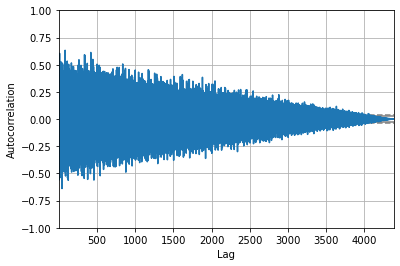

In [333]:
autocorrelation_plot(df['1st_Normal_c1_diff_1'])
plt.show()

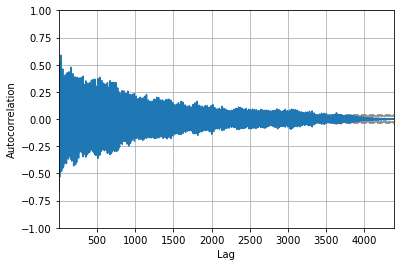

In [334]:
autocorrelation_plot(df['1st_Normal_c2_diff_1'])
plt.show()

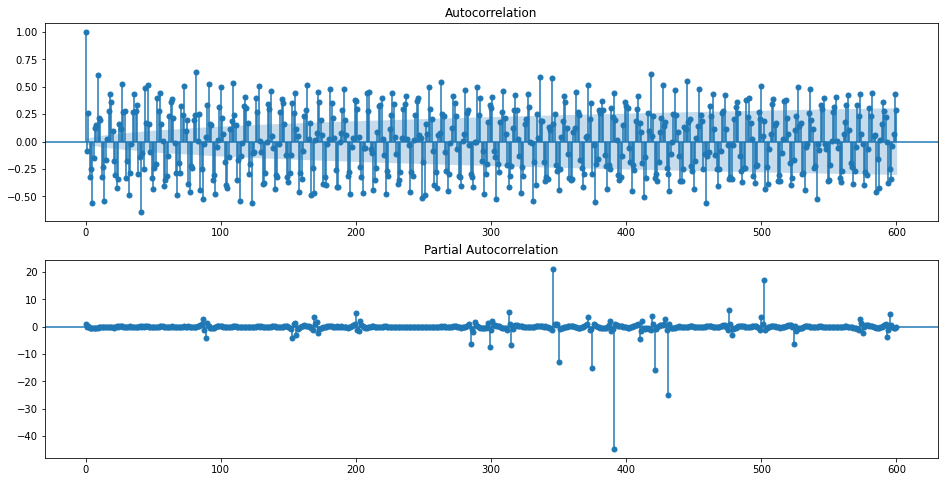

In [335]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

f, ax = plt.subplots(nrows=2, ncols=1, figsize=(16, 8))

plot_acf(df['1st_Normal_c1_diff_1'], lags=600, ax=ax[0])
plot_pacf(df['1st_Normal_c1_diff_1'], lags=600, ax=ax[1])

plt.show()

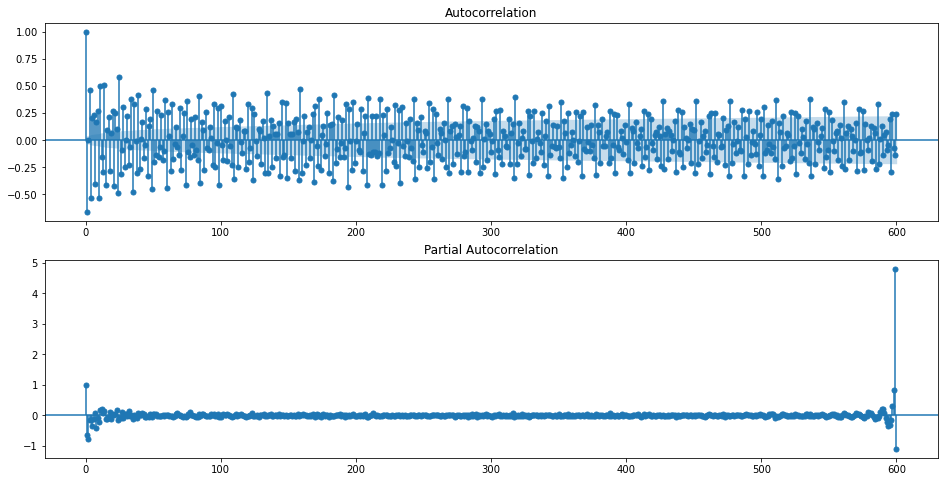

In [336]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

f, ax = plt.subplots(nrows=2, ncols=1, figsize=(16, 8))

plot_acf(df['1st_Normal_c2_diff_1'], lags=600, ax=ax[0])
plot_pacf(df['1st_Normal_c2_diff_1'], lags=600, ax=ax[1])

plt.show()

# 5. Modeling

Time series can be either univariate or multivariate:

- Univariate time series only has a signle time-dependent variable.
- Multivariate time series have a multiple time-dependent variable.

In [337]:
N_SPLITS = 3

X = df['ds']
y = df['1st_Normal_c1']

folds = TimeSeriesSplit(n_splits=N_SPLITS)

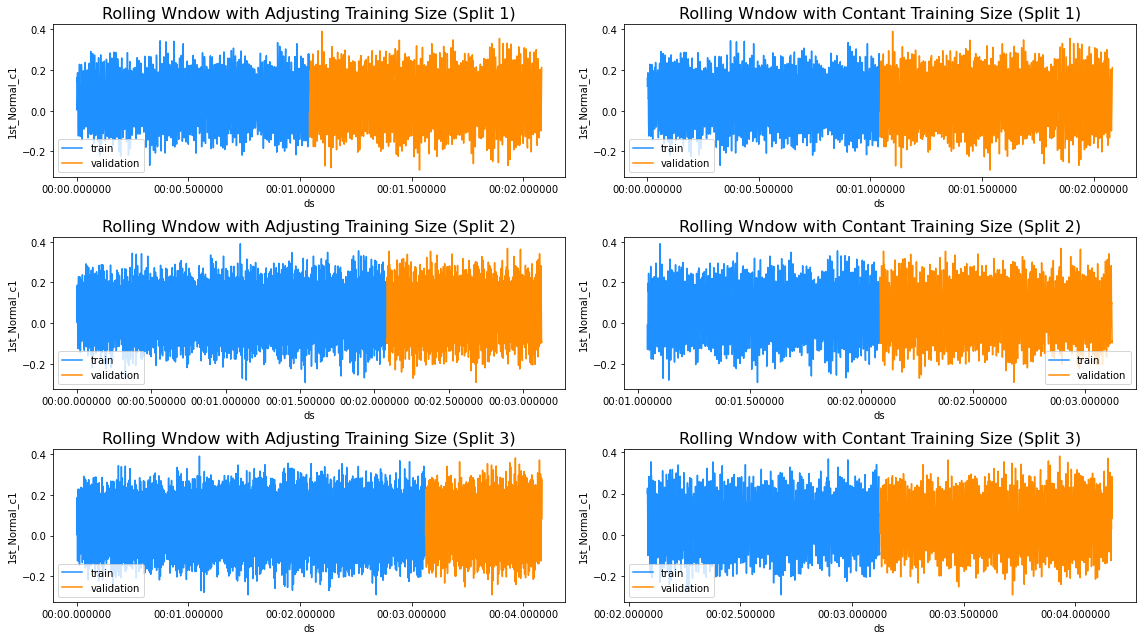

In [338]:
f, ax = plt.subplots(nrows=N_SPLITS, ncols=2, figsize=(16, 9))

for i, (train_index, valid_index) in enumerate(folds.split(X)):
    X_train, X_valid = X[train_index], X[valid_index]
    y_train, y_valid = y[train_index], y[valid_index]

    sns.lineplot(
        x=X_train, 
        y=y_train, 
        ax=ax[i,0], 
        color='dodgerblue', 
        label='train'
    )
    sns.lineplot(
        x=X_train[len(X_train) - len(X_valid):(len(X_train) - len(X_valid) + len(X_valid))], 
        y=y_train[len(X_train) - len(X_valid):(len(X_train) - len(X_valid) + len(X_valid))], 
        ax=ax[i,1], 
        color='dodgerblue', 
        label='train'
    )
    
    for j in range(2):
        sns.lineplot(x=X_valid, y=y_valid, ax=ax[i,j], color='darkorange', label='validation')
    
    ax[i, 0].set_title(f"Rolling Wndow with Adjusting Training Size (Split {i+1})", fontsize=16)
    ax[i, 1].set_title(f"Rolling Wndow with Contant Training Size (Split {i+1})", fontsize=16)
    
for i in range(N_SPLITS):
    ax[i, 0].set_xlim()
    ax[i, 1].set_xlim()
        
plt.tight_layout()
plt.show()

The idea with this plot is to understand which train and test set are we using to fit the model in each iteration.

## 5.1 Models for Univariate Time Series

First of all, we are going to analize univariate TimeSeries forecasting.

In [339]:
train_size = int(0.85 * len(df))
test_size = len(df) - train_size

univariate_df = df[['ds', '1st_Normal_c1']].copy()
univariate_df.columns = ['ds', 'y']

train = univariate_df.iloc[:train_size, :]

x_train, y_train = pd.DataFrame(univariate_df.iloc[:train_size, 0]), pd.DataFrame(univariate_df.iloc[:train_size, 1])
x_valid, y_valid = pd.DataFrame(univariate_df.iloc[train_size:, 0]), pd.DataFrame(univariate_df.iloc[train_size:, 1])

print(len(train), len(x_valid))

3727 658


### 5.1.1 Prophet

In [340]:
# Train the model
model = Prophet()
model.fit(train)

# Predict on valid set
y_pred = model.predict(x_valid)

# Calcuate metrics
score_mae = mean_absolute_error(y_valid, y_pred.tail(test_size)['yhat'])
score_rmse = math.sqrt(mean_squared_error(y_valid, y_pred.tail(test_size)['yhat']))

                       
print(Fore.GREEN + 'MAE: {}'.format(score_mae))
print(Fore.GREEN + 'RMSE: {}'.format(score_rmse))

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -230.229
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2113.37   8.55779e-05       98.5431      0.4009      0.4009      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     121       2113.43   8.36509e-05       100.382   8.485e-07       0.001      185  LS failed, Hessian reset 
     153       2113.44   7.71035e-06       100.421   7.526e-08       0.001      260  LS failed, Hessian reset 
     179       2113.44   1.70436e-07       102.001      0.2951           1      292   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
MAE: 0.11715302842106533
RMSE: 0.1384410922636163


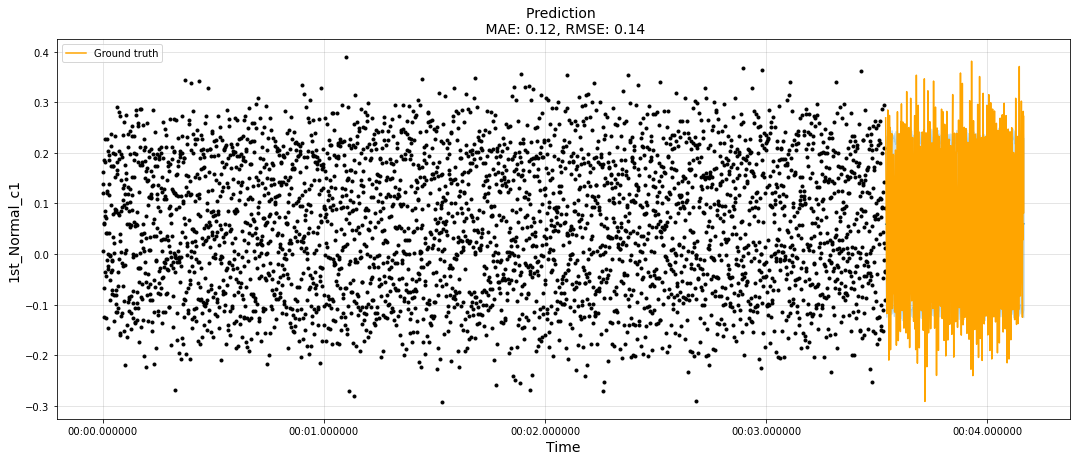

In [341]:
# Plot the forecast
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,6))

model.plot(y_pred, ax=ax)
sns.lineplot(x=x_valid['ds'], y=y_valid['y'], ax=ax, color='orange', label='Ground truth')

ax.set_title(f'Prediction \n MAE: {score_mae:.2f}, RMSE: {score_rmse:.2f}', fontsize=14)
ax.set_xlabel(xlabel='Time', fontsize=14)
ax.set_ylabel(ylabel='1st_Normal_c1', fontsize=14)

plt.show()

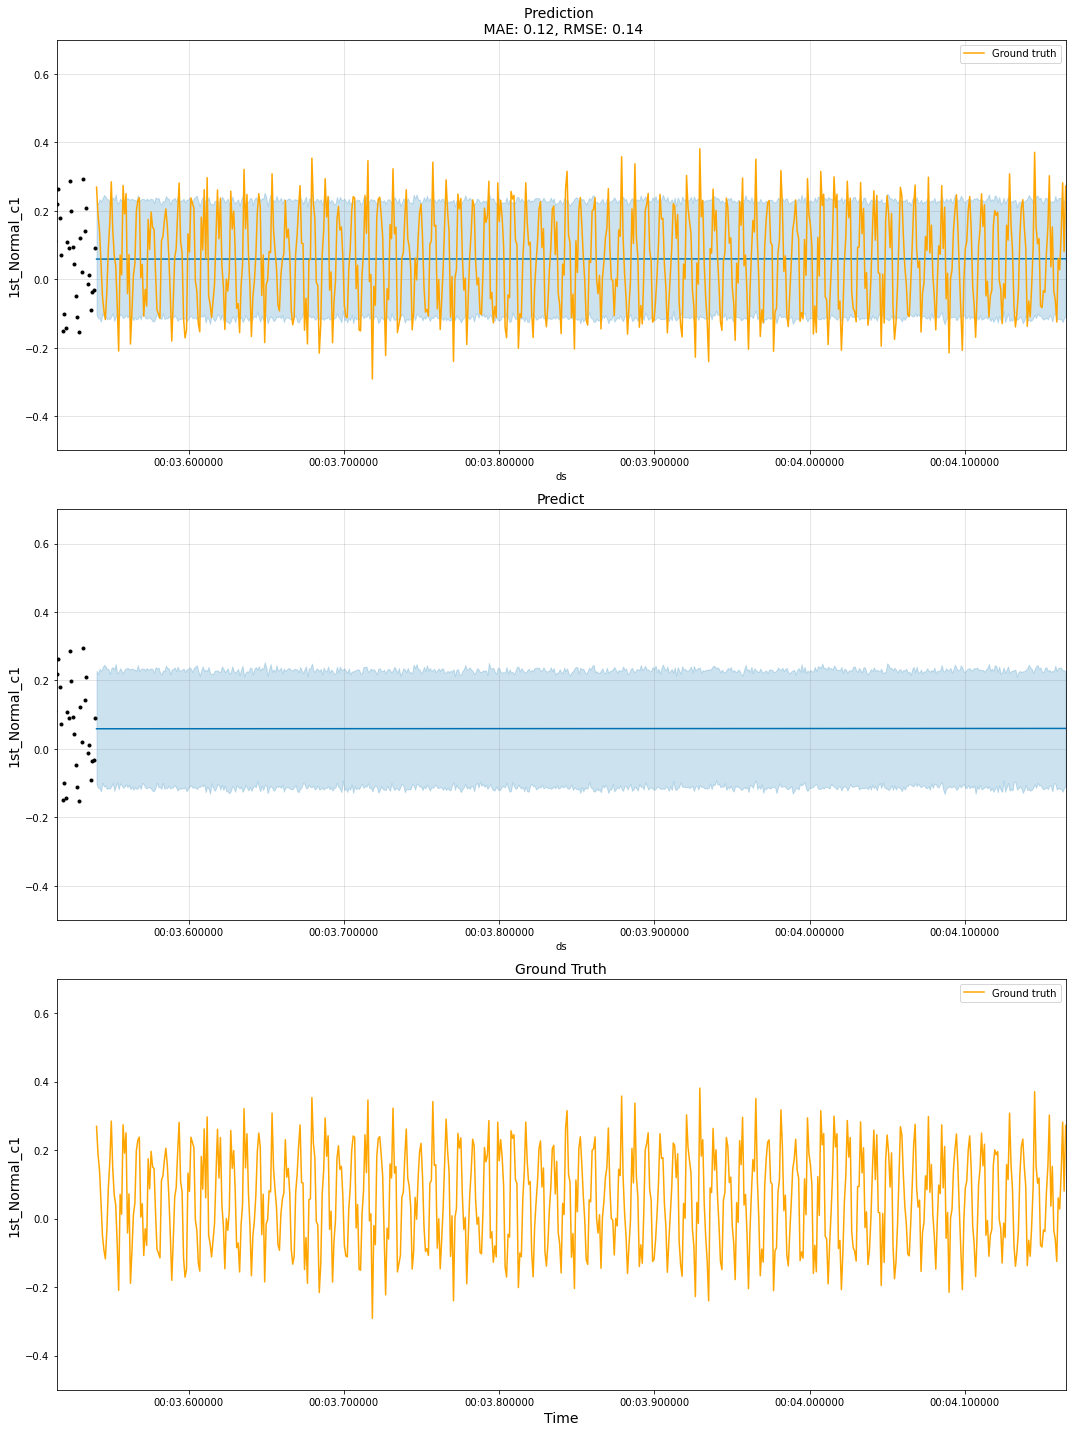

In [342]:
# Plot the forecast
f, ax = plt.subplots(nrows=3, ncols=1, figsize=(15,20))

model.plot(y_pred, ax=ax[0])
sns.lineplot(x=x_valid['ds'], y=y_valid['y'], ax=ax[0], color='orange', label='Ground truth')
ax[0].set_title(f'Prediction \n MAE: {score_mae:.2f}, RMSE: {score_rmse:.2f}', fontsize=14)

model.plot(y_pred, ax=ax[1])
ax[1].set_title('Predict', fontsize=14)

sns.lineplot(x=x_valid['ds'], y=y_valid['y'], ax=ax[2], color='orange', label='Ground truth')
ax[2].set_xlabel(xlabel='Time', fontsize=14)
ax[2].set_title('Ground Truth', fontsize=14)

for i in range(3):
    ax[i].set_ylabel(ylabel='1st_Normal_c1', fontsize=14)
    ax[i].set_xlim([df['ds'][3700], df['ds'][4384]])
    ax[i].set_ylim(-0.5, 0.7)
    
plt.tight_layout()
plt.show()

### 5.1.2 ARIMA

In [346]:
# fit model
model = ARIMA(y_train, order=(2,0,3))
model_fit = model.fit()

# Prediction with ARIMA
y_pred, se, conf = model_fit.forecast(658)

# Calcuate metrics
score_mae = mean_absolute_error(y_valid, y_pred)
score_rmse = math.sqrt(mean_squared_error(y_valid, y_pred))

print(Fore.GREEN + 'RMSEL {}'.format(score_rmse))

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.70433D+00    |proj g|=  1.80485D-01

At iterate    5    f= -1.70433D+00    |proj g|=  7.20966D-02


 This problem is unconstrained.



At iterate   10    f= -1.70437D+00    |proj g|=  2.05193D-01

At iterate   15    f= -1.70439D+00    |proj g|=  1.97100D-02

At iterate   20    f= -1.70482D+00    |proj g|=  3.58342D-01

At iterate   25    f= -1.70507D+00    |proj g|=  1.03013D-02

At iterate   30    f= -1.70509D+00    |proj g|=  2.82613D-01

At iterate   35    f= -1.70529D+00    |proj g|=  8.06910D-03

At iterate   40    f= -1.70529D+00    |proj g|=  6.84208D-04



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   45    f= -1.70529D+00    |proj g|=  6.58917D-04

At iterate   50    f= -1.70529D+00    |proj g|=  3.96749D-04

At iterate   55    f= -1.70529D+00    |proj g|=  1.21589D-03

At iterate   60    f= -1.70529D+00    |proj g|=  4.96203D-04

At iterate   65    f= -1.70529D+00    |proj g|=  1.95999D-04
  ys=-1.102E-19  -gs= 2.151E-19 BFGS update SKIPPED

At iterate   70    f= -1.70529D+00    |proj g|=  7.96030D-05

At iterate   75    f= -1.70529D+00    |proj g|=  2.25531D-04

At iterate   80    f= -1.70529D+00    |proj g|=  3.51830D-04

At iterate   85    f= -1.70529D+00    |proj g|=  2.51354D-04

At iterate   90    f= -1.70529D+00    |proj g|=  1.20550D-03

At iterate   95    f= -1.70529D+00    |proj g|=  1.15041D-04



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate  100    f= -1.70529D+00    |proj g|=  7.02949D-04

At iterate  105    f= -1.70529D+00    |proj g|=  8.93197D-04

At iterate  110    f= -1.70529D+00    |proj g|=  3.67351D-04
  ys=-6.990E-21  -gs= 9.687E-20 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate  115    f= -1.70529D+00    |proj g|=  4.89386D-04



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate  120    f= -1.70529D+00    |proj g|=  4.30278D-04

At iterate  125    f= -1.70529D+00    |proj g|=  5.46563D-04

At iterate  130    f= -1.70529D+00    |proj g|=  4.53793D-04

At iterate  135    f= -1.70529D+00    |proj g|=  1.29874D-04

At iterate  140    f= -1.70529D+00    |proj g|=  4.47686D-04

At iterate  145    f= -1.70529D+00    |proj g|=  5.97722D-04

At iterate  150    f= -1.70529D+00    |proj g|=  3.54672D-04

At iterate  155    f= -1.70529D+00    |proj g|=  3.96838D-04

At iterate  160    f= -1.70529D+00    |proj g|=  2.31526D-04

At iterate  165    f= -1.70529D+00    |proj g|=  4.79505D-04
  ys=-5.624E-19  -gs= 1.916E-18 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate  170    f= -1.70529D+00    |proj g|=  2.65876D-04

At iterate  175    f= -1.70529D+00    |proj g|=  5.55667D-04

At iterate  180    f= -1.70529D+00    |proj g|=  3.05977D-04

At iterate  185    f= -1.70529D+00    |proj g|=  1.82387D-04
  ys=-3.131E-12  -gs= 1.823E-12 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate  190    f= -1.70529D+00    |proj g|=  2.07701D-04

At iterate  195    f= -1.70529D+00    |proj g|=  3.54627D-04

At iterate  200    f= -1.70529D+00    |proj g|=  3.31934D-04



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate  205    f= -1.70529D+00    |proj g|=  3.27782D-04

At iterate  210    f= -1.70529D+00    |proj g|=  1.27116D-03

At iterate  215    f= -1.70529D+00    |proj g|=  7.63389D-04

At iterate  220    f= -1.70529D+00    |proj g|=  6.11866D-04

At iterate  225    f= -1.70529D+00    |proj g|=  5.70188D-04

At iterate  230    f= -1.70529D+00    |proj g|=  5.26024D-04



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate  235    f= -1.70529D+00    |proj g|=  7.51355D-04

At iterate  240    f= -1.70529D+00    |proj g|=  4.41447D-04

At iterate  245    f= -1.70529D+00    |proj g|=  8.22586D-03

At iterate  250    f= -1.70529D+00    |proj g|=  3.20322D-04

At iterate  255    f= -1.70529D+00    |proj g|=  2.29727D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6    256    657      9     4     0   1.887D-04  -1.705D+00
  F =  -1.7052921765547466     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RMSEL 0.06443271263798886


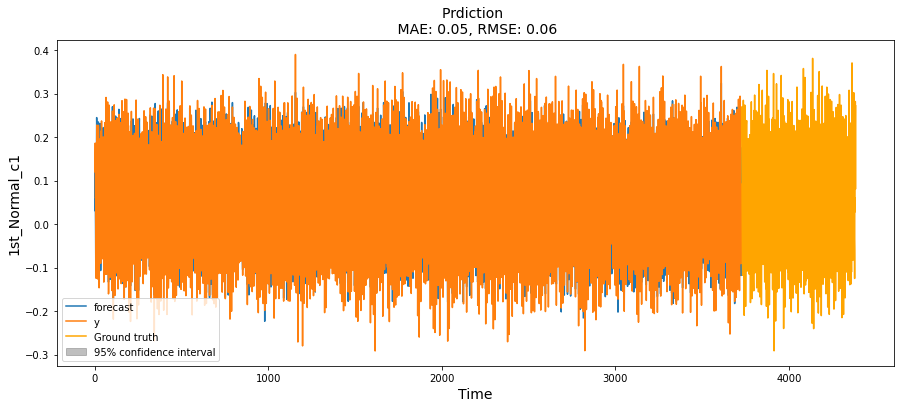

In [347]:
y, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,6))

model_fit.plot_predict(1, 3727, ax=ax)
sns.lineplot(x=x_valid.index, y=y_valid['y'], ax=ax, color='orange', label='Ground truth')

ax.set_title(f'Prdiction \n MAE: {score_mae:.2f}, RMSE: {score_rmse:.2f}', fontsize=14)
ax.set_xlabel(xlabel='Time', fontsize=14)
ax.set_ylabel(ylabel='1st_Normal_c1', fontsize=14)

ax.set_ylim()
plt.show()

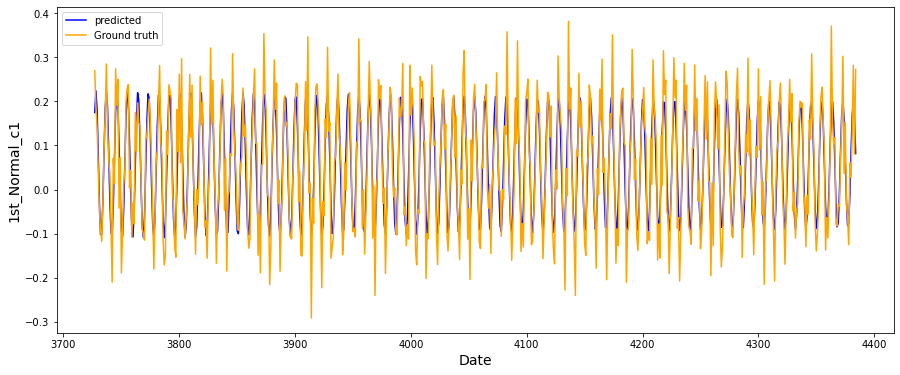

In [348]:
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,6))

sns.lineplot(x=x_valid.index, y=y_pred, ax=ax, color='blue', label='predicted')
sns.lineplot(x=x_valid.index, y=y_valid['y'], ax=ax, color='orange', label='Ground truth') #navajowhite

ax.set_xlabel(xlabel='Date', fontsize=14)
ax.set_ylabel(ylabel='1st_Normal_c1', fontsize=14)

plt.show()

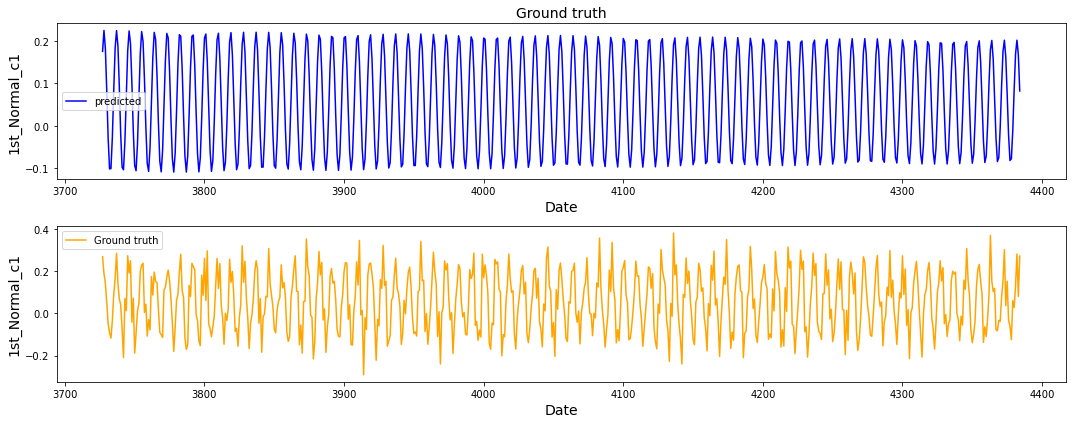

In [351]:
f, ax = plt.subplots(nrows=2, ncols=1, figsize=(15,6))

sns.lineplot(x=x_valid.index, y=y_pred, ax=ax[0], color='blue', label='predicted')
ax[0].set_title('Prdiction', fontsize=14)

sns.lineplot(x=x_valid.index, y=y_valid['y'], ax=ax[1], color='orange', label='Ground truth') #navajowhite
ax[0].set_title('Ground truth', fontsize=14)

for i in range(2):
    ax[i].set_xlabel(xlabel='Date', fontsize=14)
    ax[i].set_ylabel(ylabel='1st_Normal_c1', fontsize=14)

plt.tight_layout()
plt.show()

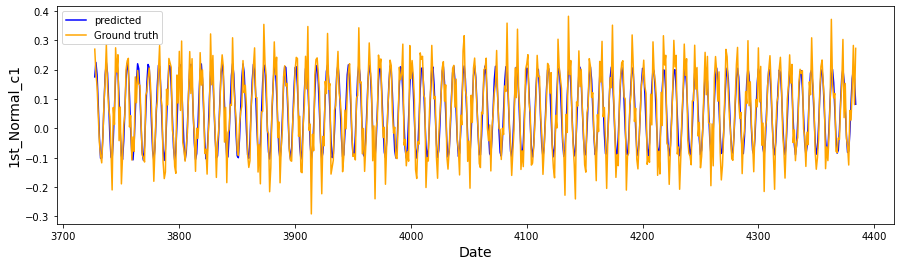

In [353]:
f, ax = plt.subplots(1)
f.set_figheight(4)
f.set_figwidth(15)

sns.lineplot(x=x_valid.index, y=y_pred, ax=ax, color='blue', label='predicted') #navajowhite
sns.lineplot(x=x_valid.index, y=y_valid['y'], ax=ax, color='orange', label='Ground truth') #navajowhite

ax.set_xlabel(xlabel='Date', fontsize=14)
ax.set_ylabel(ylabel='1st_Normal_c1', fontsize=14)

plt.show()

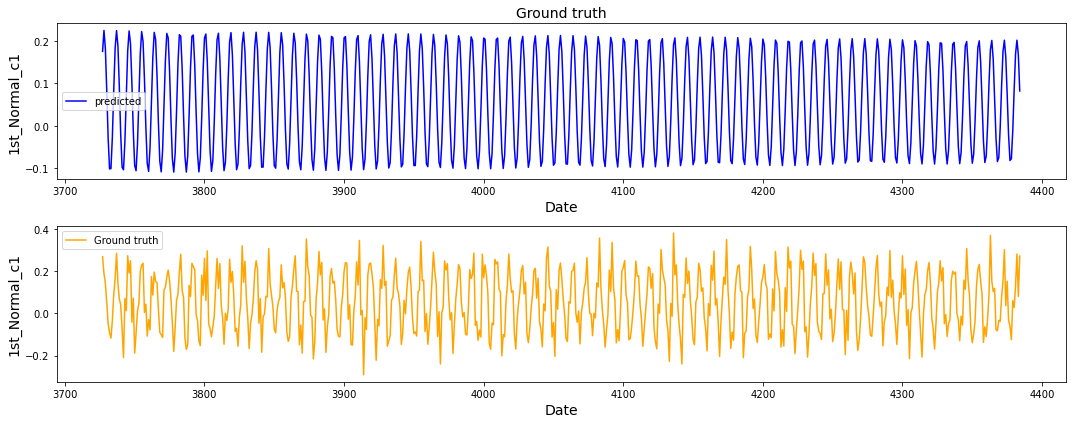

In [355]:
f, ax = plt.subplots(nrows=2, ncols=1, figsize=(15,6))

sns.lineplot(x=x_valid.index, y=y_pred, ax=ax[0], color='blue', label='predicted') #navajowhite
ax[0].set_title('Prdiction', fontsize=14)

sns.lineplot(x=x_valid.index, y=y_valid['y'], ax=ax[1], color='orange', label='Ground truth') #navajowhite
ax[0].set_title('Ground truth', fontsize=14)

for i in range(2):
    ax[i].set_xlabel(xlabel='Date', fontsize=14)
    ax[i].set_ylabel(ylabel='1st_Normal_c1', fontsize=14)

plt.tight_layout()
plt.show()

### 5.1.3 Auto-ARIMA

In [356]:
model = pm.auto_arima(y_train, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-5655.745, Time=0.23 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-3785.045, Time=0.10 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-5625.282, Time=0.17 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-5016.999, Time=0.27 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-5681.180, Time=0.57 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-5711.898, Time=0.25 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=-7054.804, Time=0.60 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=-7149.449, Time=0.84 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=-8756.779, Time=1.39 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-8703.057, Time=1.07 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=-8832.796, Time=1.52 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=-8740.128, Time=1.24 sec
 ARIMA(3,0,3)(0,0,0)[0] intercept   : AIC=-11079.245, Time=4.12 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=-11055.937, Time=3.34 sec
 ARIMA(3,0,2)(0,0

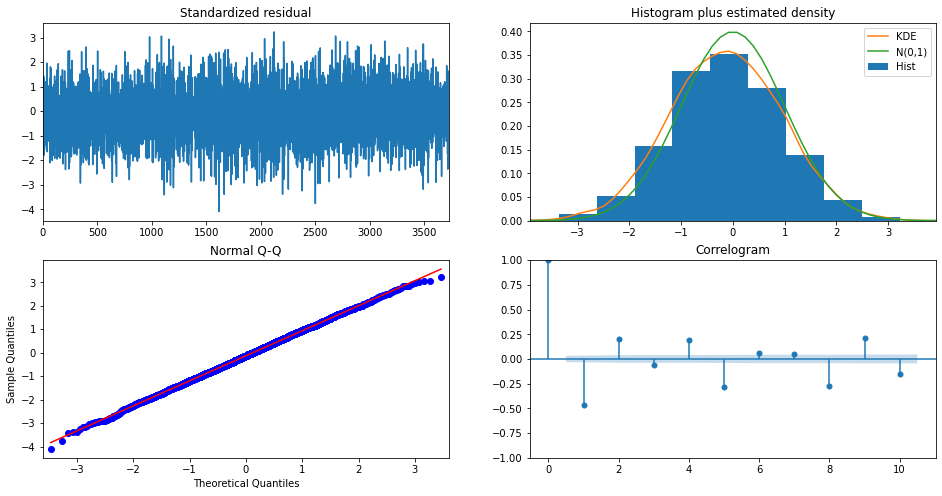

In [357]:
model.plot_diagnostics(figsize=(16,8))
plt.show()

### 5.1.4 LSTM

In [358]:
df

ds  1st_Normal_c1  1st_Normal_c2  \
0    2020-11-16 00:00:00.000000       0.005162      -0.243085   
1    2020-11-16 00:00:00.000950       0.120709      -0.867241   
2    2020-11-16 00:00:00.001900       0.162908      -0.127798   
3    2020-11-16 00:00:00.002850       0.138114      -0.109674   
4    2020-11-16 00:00:00.003800       0.186586      -0.079596   
...                         ...            ...            ...   
4380 2020-11-16 00:00:04.161000       0.028045      -0.222593   
4381 2020-11-16 00:00:04.161950       0.132557      -0.068970   
4382 2020-11-16 00:00:04.162900       0.281974      -0.573680   
4383 2020-11-16 00:00:04.163850       0.080598      -0.370274   
4384 2020-11-16 00:00:04.164800       0.272045      -2.998690   

      1st_Normal_c1_log  1st_Normal_c2_log  1st_Normal_c1_diff_1  \
0             -5.266340          -1.414343              0.000000   
1             -2.114372          -0.142438              0.115547   
2             -1.814572          -2.057304              0.042199   
3             -1.979679          -2.210245             -0.024794   
4             -1.678865          -2.530794              0.048472   
...                 ...                ...                   ...   
4380          -3.573956          -1.502409             -0.032590   
4381          -2.020743          -2.674087              0.104512   
4382          -1.265941          -0.555684              0.149417   
4383          -2.518280          -0.993511             -0.201376   
4384          -1.301787           1.098176              0.191447   

      1st_Normal_c2_diff_1  second  microsecond    us_sin    us_cos  \
0                 0.000000       0            0  0.000000  1.000000   
1                -0.624156       0          950  0.005969  0.999982   
2                 0.739443       0         1900  0.011938  0.999929   
3                 0.018124       0         2850  0.017906  0.999840   
4                 0.030078       0         3800  0.023874  0.999715   
...                    ...     ...          ...       ...       ...   
4380              0.230876       4       161000  0.847678  0.530511   
4381              0.153624       4       161950  0.850829  0.525442   
4382             -0.504710       4       162900  0.853951  0.520354   
4383              0.203405       4       163850  0.857041  0.515248   
4384             -2.628416       4       164800  0.860102  0.510123   

      1st_Normal_c1_trend  1st_Normal_c1_seasonal  1st_Normal_c2_trend  \
0                0.055524               -0.006783            -0.340252   
1                0.055514                0.002979            -0.340285   
2                0.055504                0.003637            -0.340317   
3                0.055494                0.009246            -0.340350   
4                0.055484                0.000157            -0.340383   
...                   ...                     ...                  ...   
4380             0.057026               -0.006783            -0.343665   
4381             0.057029                0.002979            -0.343673   
4382             0.057032                0.003637            -0.343681   
4383             0.057035                0.009246            -0.343689   
4384             0.057038                0.000157            -0.343697   

      1st_Normal_c2_seasonal  
0                  -0.032904  
1                   0.022644  
2                   0.000115  
3                  -0.007375  
4                  -0.026703  
...                      ...  
4380               -0.032904  
4381                0.022644  
4382                0.000115  
4383               -0.007375  
4384               -0.026703  

[4385 rows x 15 columns]

In [359]:
univariate_df

ds         y
0    2020-11-16 00:00:00.000000  0.005162
1    2020-11-16 00:00:00.000950  0.120709
2    2020-11-16 00:00:00.001900  0.162908
3    2020-11-16 00:00:00.002850  0.138114
4    2020-11-16 00:00:00.003800  0.186586
...                         ...       ...
4380 2020-11-16 00:00:04.161000  0.028045
4381 2020-11-16 00:00:04.161950  0.132557
4382 2020-11-16 00:00:04.162900  0.281974
4383 2020-11-16 00:00:04.163850  0.080598
4384 2020-11-16 00:00:04.164800  0.272045

[4385 rows x 2 columns]

In [360]:
data = univariate_df.filter(['y'])

# Converter the dataframe to a numpy array
dataset = data.values

scaler = MinMaxScaler(feature_range=(-1, 0))
scaled_data = scaler.fit_transform(dataset)

scaled_data[:10]

array([[-0.56474422],
       [-0.39525648],
       [-0.33335811],
       [-0.36972687],
       [-0.29862647],
       [-0.48381668],
       [-0.48268664],
       [-0.67002981],
       [-0.75440648],
       [-0.62337489]])

In [361]:
# Defines the rolling window
look_back = 18
# Split into train and test sets
train, test = scaled_data[:train_size-look_back, :], scaled_data[train_size-look_back:,:]

def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(look_back, len(dataset)):
        a = dataset[i-look_back:i, 0]
        X.append(a)
        Y.append(dataset[i, 0])
    return np.array(X), np.array(Y)

x_train, y_train = create_dataset(train, look_back)
x_test, y_test = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
x_train = np.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1]))
x_test = np.reshape(x_test, (x_test.shape[0], 1, x_test.shape[1]))

print(len(x_train), len(x_test))

3691 658


In [362]:
print(x_train)

[[[-0.56474422 -0.39525648 -0.33335811 ... -0.46765302 -0.63698558
   -0.75714086]]

 [[-0.39525648 -0.33335811 -0.36972687 ... -0.63698558 -0.75714086
   -0.59043121]]

 [[-0.33335811 -0.36972687 -0.29862647 ... -0.75714086 -0.59043121
   -0.51024463]]

 ...

 [[-0.75741408 -0.46950436 -0.41658944 ... -0.46635906 -0.79235554
   -0.71917212]]

 [[-0.46950436 -0.41658944 -0.25753429 ... -0.79235554 -0.71917212
   -0.78076886]]

 [[-0.41658944 -0.25753429 -0.19897138 ... -0.71917212 -0.78076886
   -0.41248022]]]


In [363]:
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Comfile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(x_train, y_train, batch_size=1, epochs=5, validation_data=(x_test, y_test))

model.summary()

Train on 3691 samples, validate on 658 samples
Epoch 1/5
3691/3691 [==============================] - 43s 12ms/step - loss: 0.0077 - val_loss: 0.0069
Epoch 2/5
3691/3691 [==============================] - 42s 11ms/step - loss: 0.0058 - val_loss: 0.0061
Epoch 3/5
3691/3691 [==============================] - 42s 11ms/step - loss: 0.0055 - val_loss: 0.0058
Epoch 4/5
3691/3691 [==============================] - 42s 11ms/step - loss: 0.0052 - val_loss: 0.0051
Epoch 5/5
3691/3691 [==============================] - 42s 11ms/step - loss: 0.0053 - val_loss: 0.0050
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_11 (LSTM)               (None, 1, 128)            75264     
_________________________________________________________________
lstm_12 (LSTM)               (None, 64)                49408     
_________________________________________________________________
dense_11 (Dense)    

In [364]:
# Lets predict with the model
train_predict = model.predict(x_train)
test_predict = model.predict(x_test)

# invert predictions
train_predict = scaler.inverse_transform(train_predict)
y_train = scaler.inverse_transform([y_train])

test_predict = scaler.inverse_transform(test_predict)
y_test = scaler.inverse_transform([y_test])

# Get the root mean squared error (RMSE) and MAE
score_rmse = np.sqrt(mean_squared_error(y_test[0], test_predict[:,0]))
score_mae = mean_absolute_error(y_test[0], test_predict[:,0])

print(Fore.GREEN + 'RMSE: {}'.format(score_rmse))
print(Fore.GREEN + 'MAE: {}'.format(score_mae))

RMSE: 0.04822901538621224
MAE: 0.03815214692472324


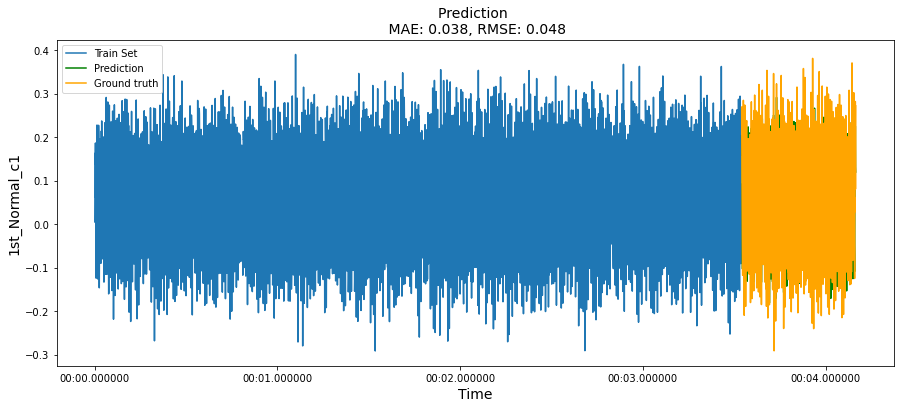

In [365]:
x_train_ticks = univariate_df.head(train_size)['ds']
y_train = univariate_df.head(train_size)['y']
x_test_ticks = univariate_df.tail(test_size)['ds']

# Plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(6)
f.set_figwidth(15)

sns.lineplot(x=x_train_ticks, y=y_train, ax=ax, label='Train Set') #navajowhite
sns.lineplot(x=x_test_ticks, y=test_predict[:,0], ax=ax, color='green', label='Prediction') #navajowhite
sns.lineplot(x=x_test_ticks, y=y_test[0], ax=ax, color='orange', label='Ground truth') #navajowhite

ax.set_title(f'Prediction \n MAE: {score_mae:.3f}, RMSE: {score_rmse:.3f}', fontsize=14)
ax.set_xlabel(xlabel='Time', fontsize=14)
ax.set_ylabel(ylabel='1st_Normal_c1', fontsize=14)

plt.show()

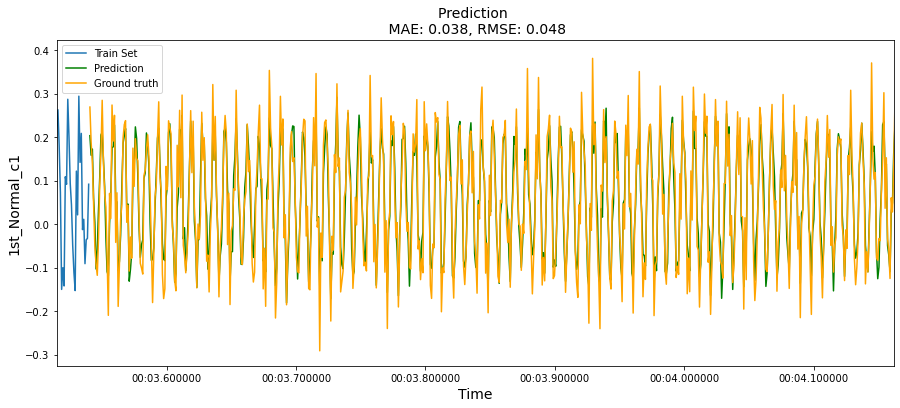

In [366]:
x_train_ticks = univariate_df.head(train_size)['ds']
y_train = univariate_df.head(train_size)['y']
x_test_ticks = univariate_df.tail(test_size)['ds']

# Plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(6)
f.set_figwidth(15)

sns.lineplot(x=x_train_ticks, y=y_train, ax=ax, label='Train Set') #navajowhite
sns.lineplot(x=x_test_ticks, y=test_predict[:,0], ax=ax, color='green', label='Prediction') #navajowhite
sns.lineplot(x=x_test_ticks, y=y_test[0], ax=ax, color='orange', label='Ground truth') #navajowhite

ax.set_title(f'Prediction \n MAE: {score_mae:.3f}, RMSE: {score_rmse:.3f}', fontsize=14)
ax.set_xlabel(xlabel='Time', fontsize=14)
ax.set_ylabel(ylabel='1st_Normal_c1', fontsize=14)
ax.set_xlim([df['ds'][3700], df['ds'][4381]])

plt.show()

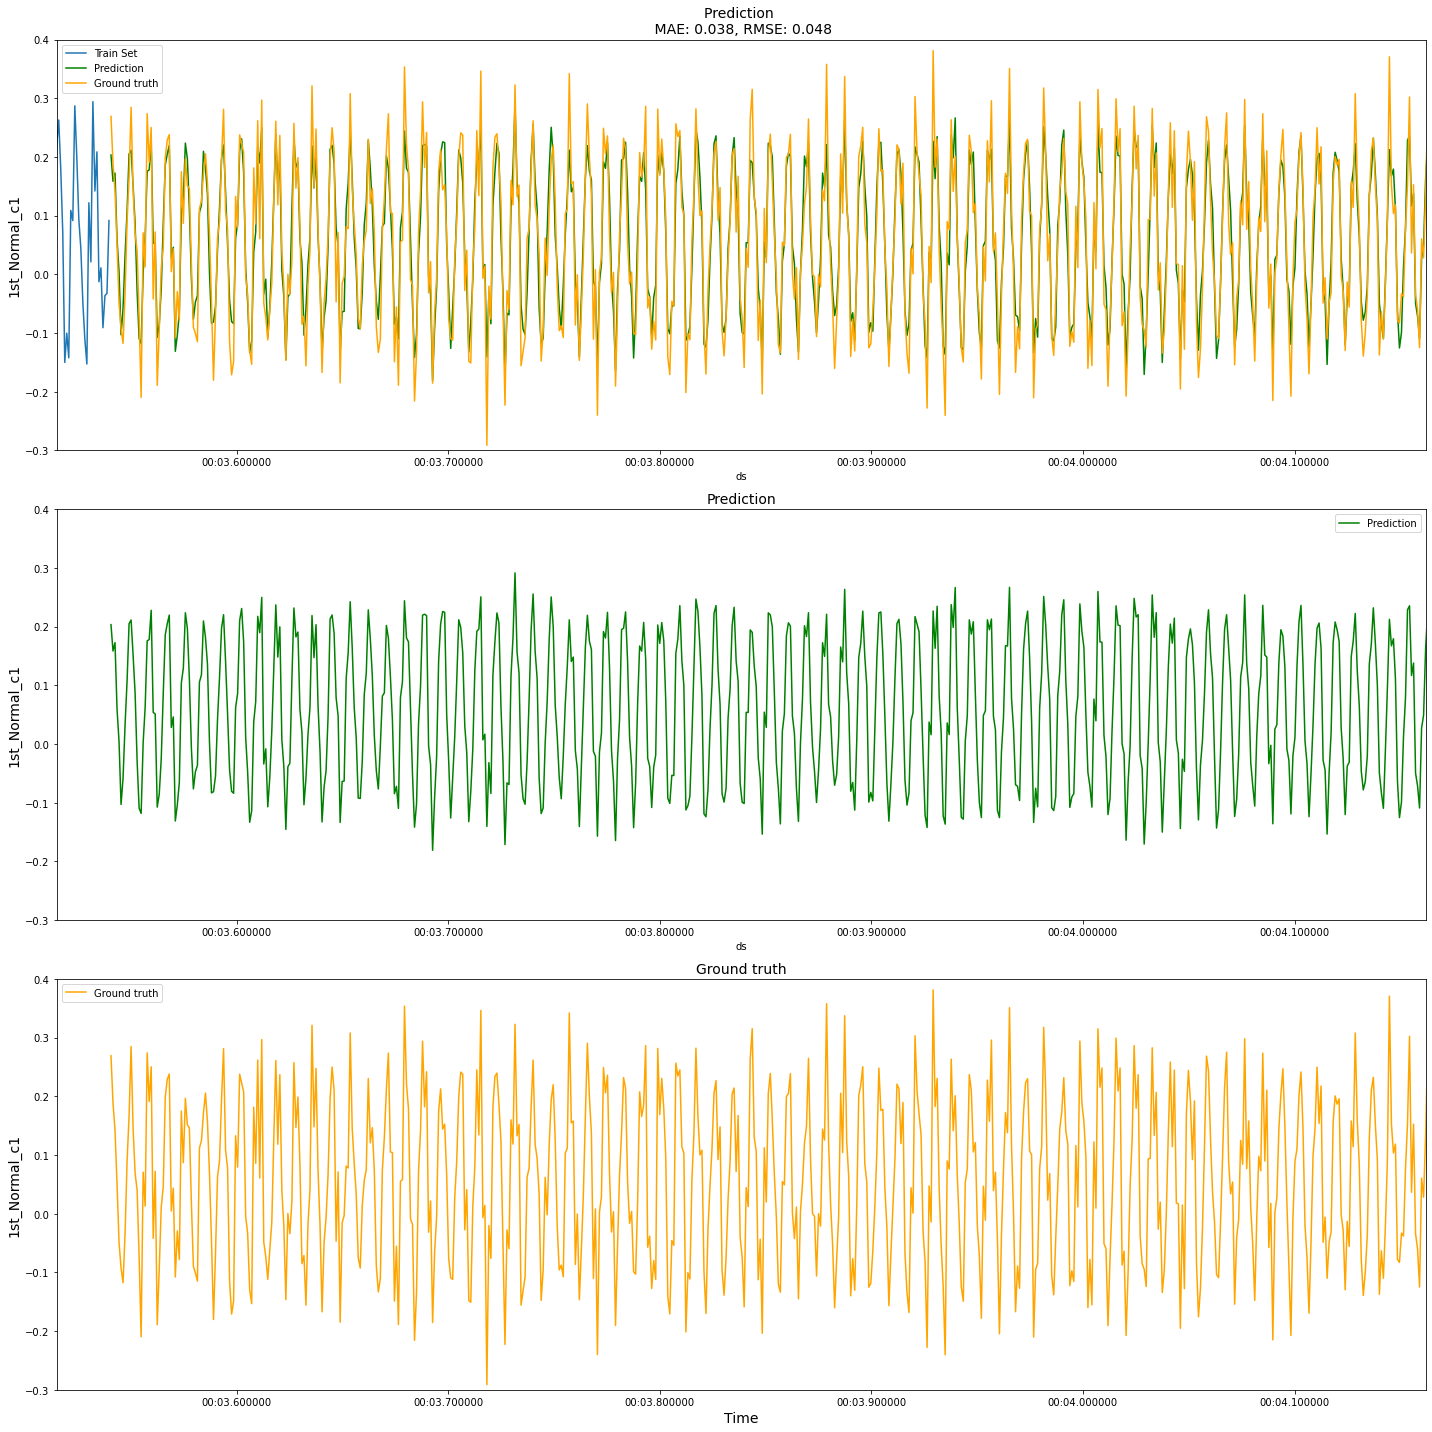

In [368]:
# Plot the forecast
f, ax = plt.subplots(nrows=3, ncols=1, figsize=(20, 20))

sns.lineplot(x=x_train_ticks, y=y_train, ax=ax[0], label='Train Set') #navajowhite
sns.lineplot(x=x_test_ticks, y=test_predict[:,0], ax=ax[0], color='green', label='Prediction') #navajowhite
sns.lineplot(x=x_test_ticks, y=y_test[0], ax=ax[0], color='orange', label='Ground truth') #navajowhite
ax[0].set_title(f'Prediction \n MAE: {score_mae:.3f}, RMSE: {score_rmse:.3f}', fontsize=14)

sns.lineplot(x=x_test_ticks, y=test_predict[:,0], ax=ax[1], color='green', label='Prediction') #navajowhite
ax[1].set_title('Prediction', fontsize=14)

sns.lineplot(x=x_test_ticks, y=y_test[0], ax=ax[2], color='orange', label='Ground truth') #navajowhite
ax[2].set_title('Ground truth', fontsize=14)
ax[2].set_xlabel(xlabel='Time', fontsize=14)


for i in range(3):
    ax[i].set_ylabel(ylabel='1st_Normal_c1', fontsize=14)
    ax[i].set_xlim([df['ds'][3700], df['ds'][4381]])
    ax[i].set_ylim([-0.3, 0.4])
    
plt.tight_layout()
plt.show()

### 5.1.5 GRU

In [380]:
univariate_df

ds         y
0    2020-11-16 00:00:00.000000  0.005162
1    2020-11-16 00:00:00.000950  0.120709
2    2020-11-16 00:00:00.001900  0.162908
3    2020-11-16 00:00:00.002850  0.138114
4    2020-11-16 00:00:00.003800  0.186586
...                         ...       ...
4380 2020-11-16 00:00:04.161000  0.028045
4381 2020-11-16 00:00:04.161950  0.132557
4382 2020-11-16 00:00:04.162900  0.281974
4383 2020-11-16 00:00:04.163850  0.080598
4384 2020-11-16 00:00:04.164800  0.272045

[4385 rows x 2 columns]

In [381]:
data = univariate_df.filter(['y'])

# Converter the dataframe to a numpy array
dataset = data.values

scaler = MinMaxScaler(feature_range=(-1, 0))
scaled_data = scaler.fit_transform(dataset)

scaled_data[:10]

array([[-0.56474422],
       [-0.39525648],
       [-0.33335811],
       [-0.36972687],
       [-0.29862647],
       [-0.48381668],
       [-0.48268664],
       [-0.67002981],
       [-0.75440648],
       [-0.62337489]])

In [382]:
# Defines the rolling window
look_back = 18
# Split into train and test sets
train, test = scaled_data[:train_size-look_back, :], scaled_data[train_size-look_back:,:]

def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(look_back, len(dataset)):
        a = dataset[i-look_back:i, 0]
        X.append(a)
        Y.append(dataset[i, 0])
    return np.array(X), np.array(Y)

x_train, y_train = create_dataset(train, look_back)
x_test, y_test = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
x_train = np.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1]))
x_test = np.reshape(x_test, (x_test.shape[0], 1, x_test.shape[1]))

print(len(x_train), len(x_test))

3691 658


In [383]:
x_train

array([[[-0.56474422, -0.39525648, -0.33335811, ..., -0.46765302,
         -0.63698558, -0.75714086]],

       [[-0.39525648, -0.33335811, -0.36972687, ..., -0.63698558,
         -0.75714086, -0.59043121]],

       [[-0.33335811, -0.36972687, -0.29862647, ..., -0.75714086,
         -0.59043121, -0.51024463]],

       ...,

       [[-0.75741408, -0.46950436, -0.41658944, ..., -0.46635906,
         -0.79235554, -0.71917212]],

       [[-0.46950436, -0.41658944, -0.25753429, ..., -0.79235554,
         -0.71917212, -0.78076886]],

       [[-0.41658944, -0.25753429, -0.19897138, ..., -0.71917212,
         -0.78076886, -0.41248022]]])

In [386]:
model = Sequential()
model.add(GRU(128, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(GRU(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Comfile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(x_train, y_train, batch_size=1, epochs=5, validation_data=(x_test, y_test))

model.summary()

Train on 3691 samples, validate on 658 samples
Epoch 1/5
3691/3691 [==============================] - 48s 13ms/step - loss: 0.0080 - val_loss: 0.0084
Epoch 2/5
3691/3691 [==============================] - 47s 13ms/step - loss: 0.0061 - val_loss: 0.0067
Epoch 3/5
3691/3691 [==============================] - 47s 13ms/step - loss: 0.0056 - val_loss: 0.0054
Epoch 4/5
3691/3691 [==============================] - 47s 13ms/step - loss: 0.0053 - val_loss: 0.0056
Epoch 5/5
3691/3691 [==============================] - 47s 13ms/step - loss: 0.0052 - val_loss: 0.0057
Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 1, 128)            56448     
_________________________________________________________________
gru_2 (GRU)                  (None, 64)                37056     
_________________________________________________________________
dense_13 (Dense)    

In [387]:
# Lets predict with the model
train_predict = model.predict(x_train)
test_predict = model.predict(x_test)

# invert predictions
train_predict = scaler.inverse_transform(train_predict)
y_train = scaler.inverse_transform([y_train])

test_predict = scaler.inverse_transform(test_predict)
y_test = scaler.inverse_transform([y_test])

# Get the root mean squared error (RMSE) and MAE
score_rmse = np.sqrt(mean_squared_error(y_test[0], test_predict[:,0]))
score_mae = mean_absolute_error(y_test[0], test_predict[:,0])

print(Fore.GREEN + 'RMSE: {}'.format(score_rmse))
print(Fore.GREEN + 'MAE: {}'.format(score_mae))

RMSE: 0.051414088287798365
MAE: 0.04095328752298999


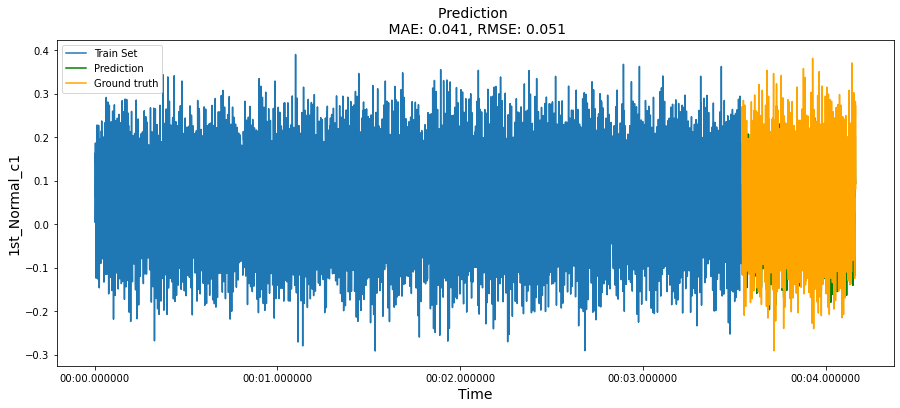

In [388]:
x_train_ticks = univariate_df.head(train_size)['ds']
y_train = univariate_df.head(train_size)['y']
x_test_ticks = univariate_df.tail(test_size)['ds']

# Plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(6)
f.set_figwidth(15)

sns.lineplot(x=x_train_ticks, y=y_train, ax=ax, label='Train Set') #navajowhite
sns.lineplot(x=x_test_ticks, y=test_predict[:,0], ax=ax, color='green', label='Prediction') #navajowhite
sns.lineplot(x=x_test_ticks, y=y_test[0], ax=ax, color='orange', label='Ground truth') #navajowhite

ax.set_title(f'Prediction \n MAE: {score_mae:.3f}, RMSE: {score_rmse:.3f}', fontsize=14)
ax.set_xlabel(xlabel='Time', fontsize=14)
ax.set_ylabel(ylabel='1st_Normal_c1', fontsize=14)

plt.show()

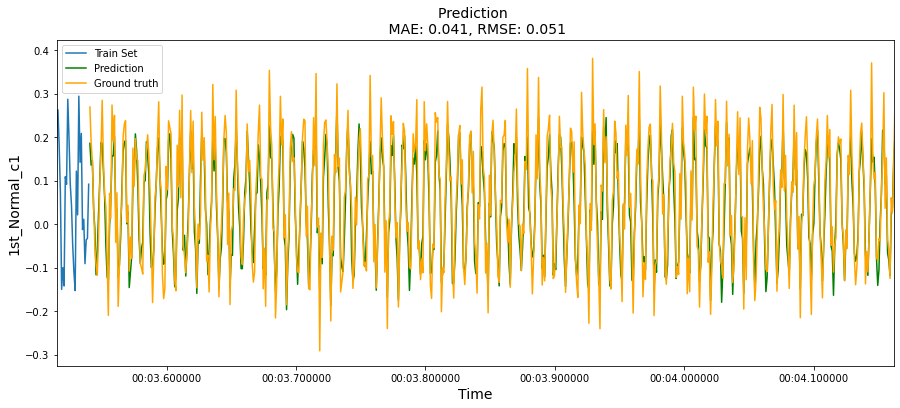

In [389]:
x_train_ticks = univariate_df.head(train_size)['ds']
y_train = univariate_df.head(train_size)['y']
x_test_ticks = univariate_df.tail(test_size)['ds']

# Plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(6)
f.set_figwidth(15)

sns.lineplot(x=x_train_ticks, y=y_train, ax=ax, label='Train Set') #navajowhite
sns.lineplot(x=x_test_ticks, y=test_predict[:,0], ax=ax, color='green', label='Prediction') #navajowhite
sns.lineplot(x=x_test_ticks, y=y_test[0], ax=ax, color='orange', label='Ground truth') #navajowhite

ax.set_title(f'Prediction \n MAE: {score_mae:.3f}, RMSE: {score_rmse:.3f}', fontsize=14)
ax.set_xlabel(xlabel='Time', fontsize=14)
ax.set_ylabel(ylabel='1st_Normal_c1', fontsize=14)
ax.set_xlim([df['ds'][3700], df['ds'][4381]])

plt.show()

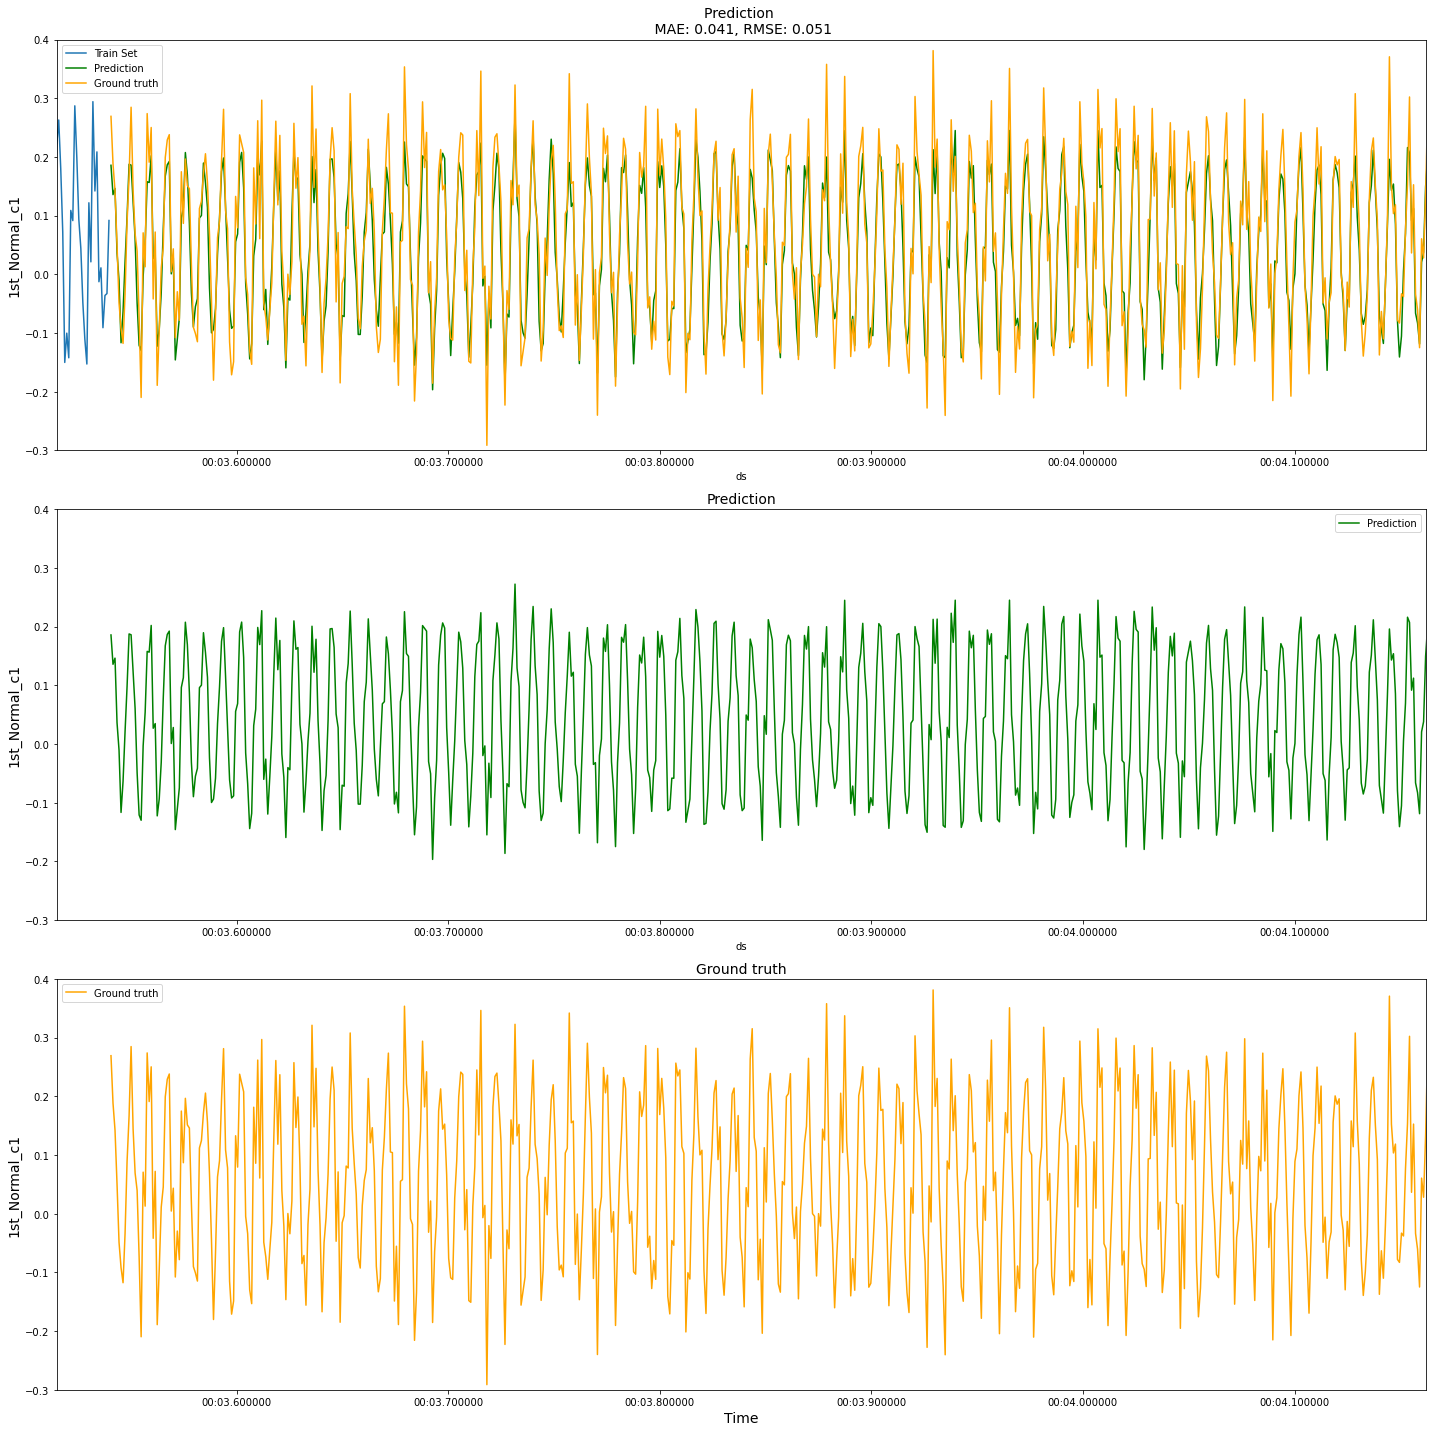

In [390]:
# Plot the forecast
f, ax = plt.subplots(nrows=3, ncols=1, figsize=(20, 20))

sns.lineplot(x=x_train_ticks, y=y_train, ax=ax[0], label='Train Set') #navajowhite
sns.lineplot(x=x_test_ticks, y=test_predict[:,0], ax=ax[0], color='green', label='Prediction') #navajowhite
sns.lineplot(x=x_test_ticks, y=y_test[0], ax=ax[0], color='orange', label='Ground truth') #navajowhite
ax[0].set_title(f'Prediction \n MAE: {score_mae:.3f}, RMSE: {score_rmse:.3f}', fontsize=14)

sns.lineplot(x=x_test_ticks, y=test_predict[:,0], ax=ax[1], color='green', label='Prediction') #navajowhite
ax[1].set_title('Prediction', fontsize=14)

sns.lineplot(x=x_test_ticks, y=y_test[0], ax=ax[2], color='orange', label='Ground truth') #navajowhite
ax[2].set_title('Ground truth', fontsize=14)
ax[2].set_xlabel(xlabel='Time', fontsize=14)


for i in range(3):
    ax[i].set_ylabel(ylabel='1st_Normal_c1', fontsize=14)
    ax[i].set_xlim([df['ds'][3700], df['ds'][4381]])
    ax[i].set_ylim([-0.3, 0.4])
    
plt.tight_layout()
plt.show()

## 5.2 Models for Multivariate Time Series

Finally, We are goging to analize multivariate TimeSeries forecasting.   
Mulivariate time series: Multiple vriables are varying over time. For example, a tri-axial accelerometer. There are three acceleations, one for each axis (x,y,z) and they vary simultaneously over time.

In [373]:
feature_columns = [
    '1st_Normal_c1',
    '1st_Normal_c2',
]

target_column = ['1st_Normal_c2']

train_size = int(0.85 * len(df))

multivariate_df = df[['ds'] + target_column + feature_columns].copy()
multivariate_df.columns = ['ds', 'y'] + feature_columns

multivariate_df

ds         y  1st_Normal_c1  1st_Normal_c2
0    2020-11-16 00:00:00.000000 -0.243085       0.005162      -0.243085
1    2020-11-16 00:00:00.000950 -0.867241       0.120709      -0.867241
2    2020-11-16 00:00:00.001900 -0.127798       0.162908      -0.127798
3    2020-11-16 00:00:00.002850 -0.109674       0.138114      -0.109674
4    2020-11-16 00:00:00.003800 -0.079596       0.186586      -0.079596
...                         ...       ...            ...            ...
4380 2020-11-16 00:00:04.161000 -0.222593       0.028045      -0.222593
4381 2020-11-16 00:00:04.161950 -0.068970       0.132557      -0.068970
4382 2020-11-16 00:00:04.162900 -0.573680       0.281974      -0.573680
4383 2020-11-16 00:00:04.163850 -0.370274       0.080598      -0.370274
4384 2020-11-16 00:00:04.164800 -2.998690       0.272045      -2.998690

[4385 rows x 4 columns]

In [374]:
train = multivariate_df.iloc[:train_size, :]
x_train, y_train = pd.DataFrame(multivariate_df.iloc[:train_size, [0,2,3]]), pd.DataFrame(multivariate_df.iloc[:train_size, 1])
x_valid, y_valid = pd.DataFrame(multivariate_df.iloc[train_size:, [0,2,3]]), pd.DataFrame(multivariate_df.iloc[train_size:, 1])

train.head()

ds         y  1st_Normal_c1  1st_Normal_c2
0 2020-11-16 00:00:00.000000 -0.243085       0.005162      -0.243085
1 2020-11-16 00:00:00.000950 -0.867241       0.120709      -0.867241
2 2020-11-16 00:00:00.001900 -0.127798       0.162908      -0.127798
3 2020-11-16 00:00:00.002850 -0.109674       0.138114      -0.109674
4 2020-11-16 00:00:00.003800 -0.079596       0.186586      -0.079596

### 5.2.1 Mulivariate Prophet

In [376]:
# Train the model
model = Prophet()
model.add_regressor('1st_Normal_c1')
model.add_regressor('1st_Normal_c2')

# fit the model with train set
model.fit(train)

# Predict on valid set
y_pred = model.predict(x_valid)

# Calcuate metrics
score_mae = mean_absolute_error(y_valid, y_pred['yhat'])
score_rmse = math.sqrt(mean_squared_error(y_valid, y_pred['yhat']))

print(Fore.GREEN + 'RMSE: {}'.format(score_rmse))

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -112.482
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       25958.7      0.012138        836610           1           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       27582.3     0.0032935        439953      0.5169           1      238   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       27895.7   0.000496789        126560           1           1      348   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       28028.1   0.000554617        120981      0.9837      0.9837      458   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       28068.6   7.67893e-05       23546.2           1           1      568   
    Iter      log prob        ||dx||      ||grad||       alpha  

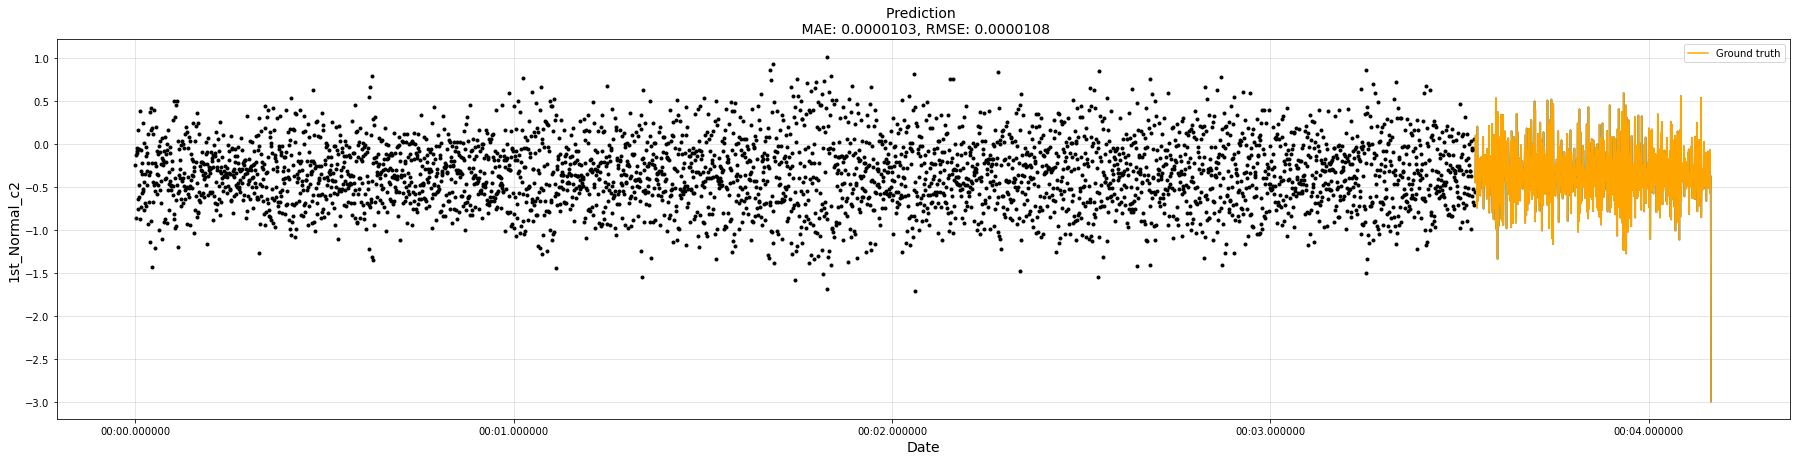

In [377]:
# Plot the gorecast
f, ax = plt.subplots(1)
f.set_figheight(6)
f.set_figwidth(25)

model.plot(y_pred, ax=ax)
sns.lineplot(x=x_valid['ds'], y=y_valid['y'], ax=ax, color='orange', label='Ground truth')

ax.set_title(f'Prediction \n MAE: {score_mae:.7f}, RMSE: {score_rmse:.7f}', fontsize=14)
ax.set_xlabel(xlabel='Date', fontsize=14)
ax.set_ylabel(ylabel='1st_Normal_c2', fontsize=14)

plt.show()

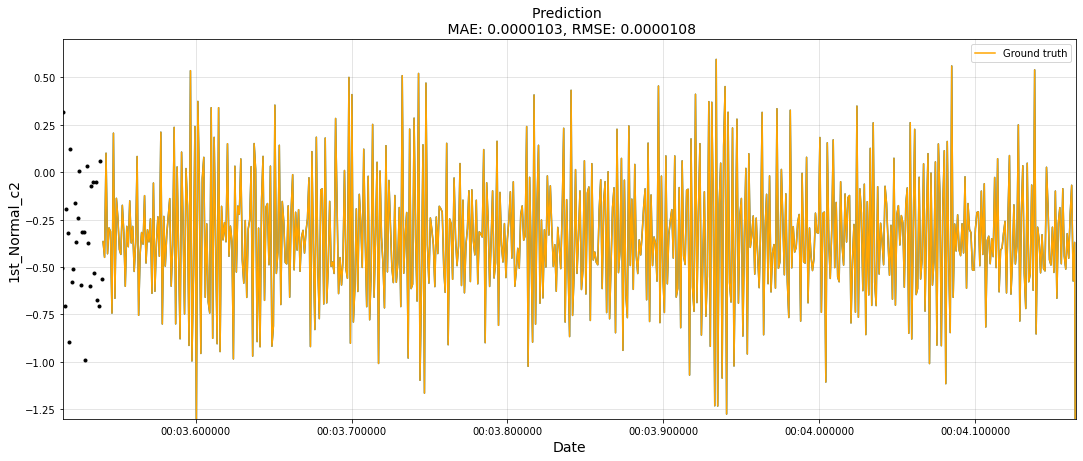

In [378]:
# Plot the gorecast
f, ax = plt.subplots(1)
f.set_figheight(6)
f.set_figwidth(15)

model.plot(y_pred, ax=ax)
sns.lineplot(x=x_valid['ds'], y=y_valid['y'], ax=ax, color='orange', label='Ground truth')

ax.set_title(f'Prediction \n MAE: {score_mae:.7f}, RMSE: {score_rmse:.7f}', fontsize=14)
ax.set_xlabel(xlabel='Date', fontsize=14)
ax.set_ylabel(ylabel='1st_Normal_c2', fontsize=14)
ax.set_xlim([df['ds'][3700], df['ds'][4384]])
ax.set_ylim(-1.3, 0.7)

plt.show()

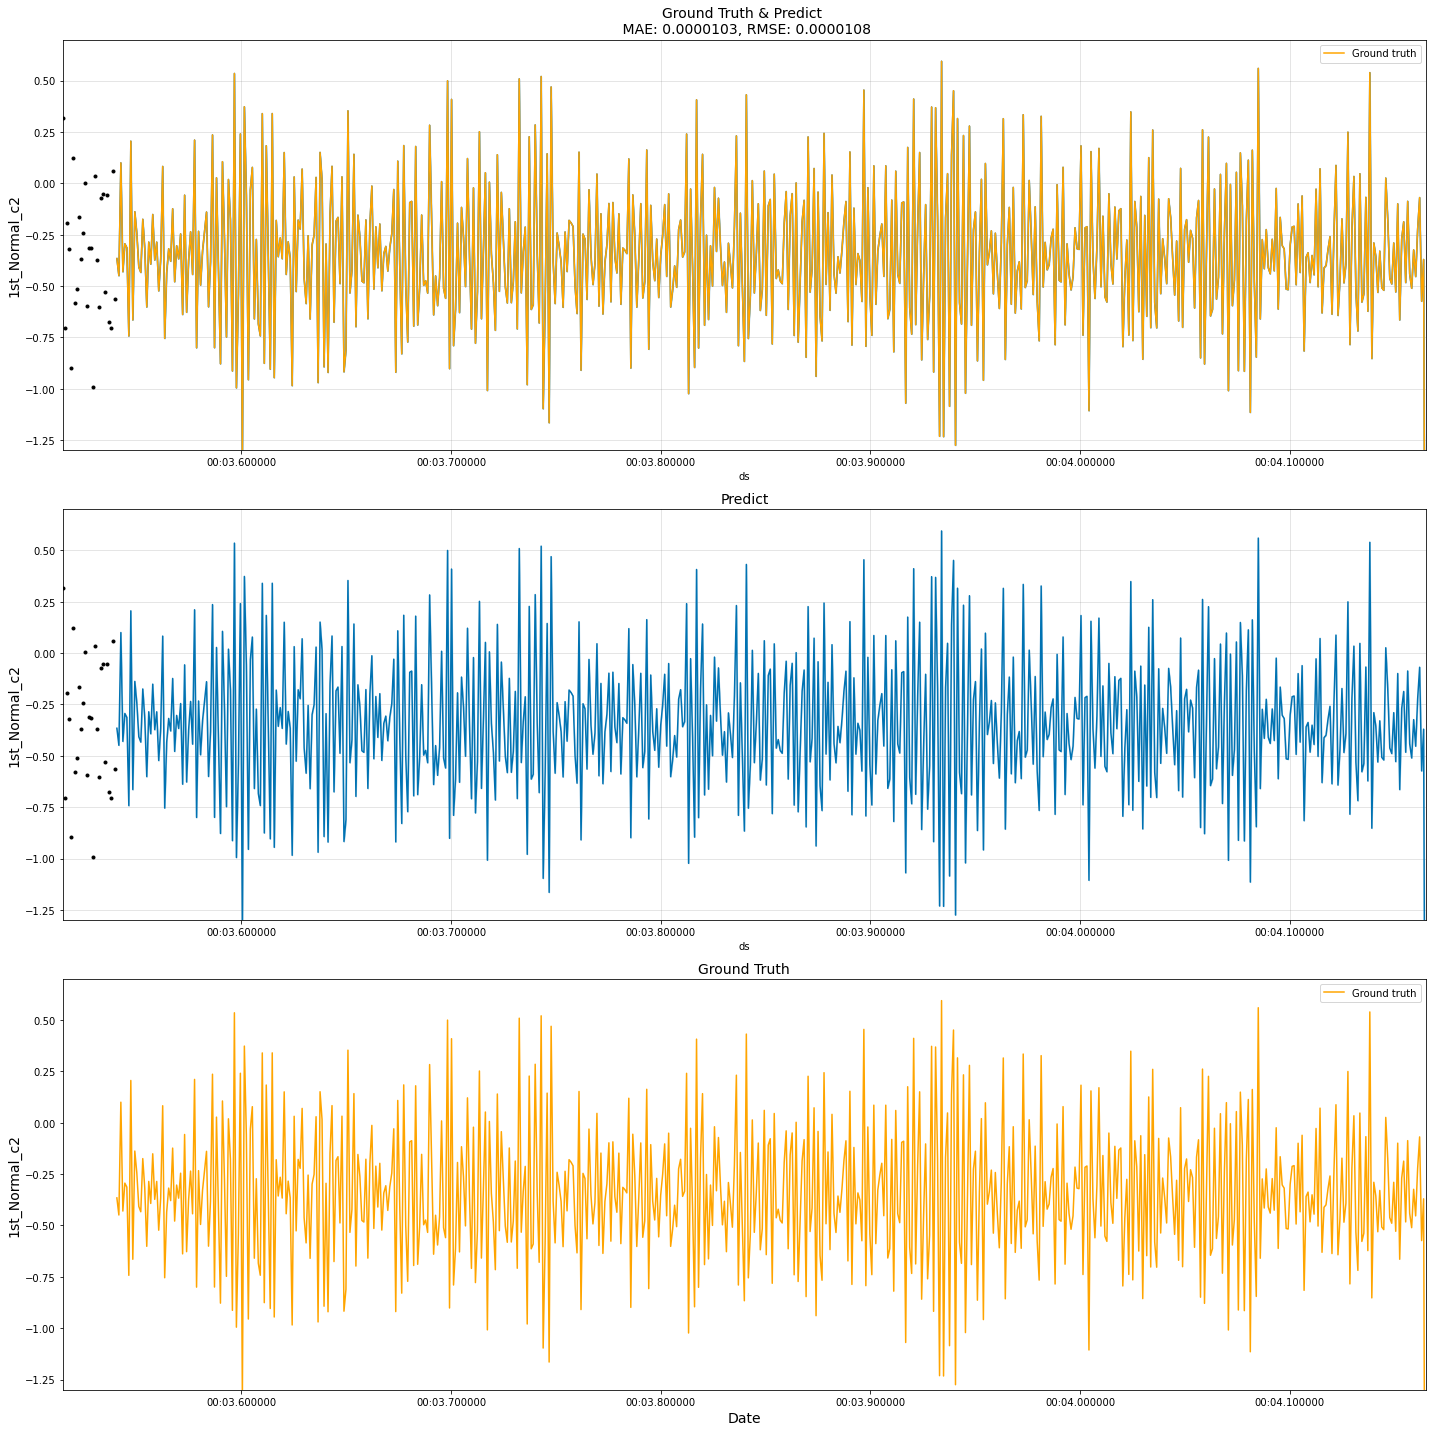

In [379]:
# Plot the gorecast
f, ax = plt.subplots(nrows=3, ncols=1, figsize=(20, 20))

model.plot(y_pred, ax=ax[0])
sns.lineplot(x=x_valid['ds'], y=y_valid['y'], ax=ax[0], color='orange', label='Ground truth')
#ax[0].set_xlabel(xlabel='Date', fontsize=14)
ax[0].set_ylabel(ylabel='1st_Normal_c2', fontsize=14)
ax[0].set_title(f'Ground Truth & Predict \n MAE: {score_mae:.7f}, RMSE: {score_rmse:.7f}', fontsize=14)

model.plot(y_pred, ax=ax[1])
#ax[1].set_xlabel(xlabel='Date', fontsize=14)
ax[1].set_ylabel(ylabel='1st_Normal_c2', fontsize=14)
ax[1].set_title('Predict', fontsize=14)

sns.lineplot(x=x_valid['ds'], y=y_valid['y'], ax=ax[2], color='orange', label='Ground truth')
ax[2].set_xlabel(xlabel='Date', fontsize=14)
ax[2].set_ylabel(ylabel='1st_Normal_c2', fontsize=14)
ax[2].set_title('Ground Truth', fontsize=14)

for i in range(3):
    ax[i].set_xlim([df['ds'][3700], df['ds'][4384]])
    ax[i].set_ylim(-1.3, 0.7)

plt.tight_layout()
plt.show()